In [ ]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Electricity consumption prediction
# Contributors: Jeong Gukho, Jeong Woogun, Kim Hyungeun, Kim Juneon, Kimm Soo Min
# Last modified date: 08/04/25

### **Library**

In [1]:
# Library
# Time
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

# File
import warnings
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image
import random
import chardet
import itertools

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy as sp
import math
from typing import List, Callable, Union, Dict, Any, Tuple

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from sklearn.tree import plot_tree
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# Machine Learning Libraries
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ParameterGrid
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
							  ExtraTreesClassifier, ExtraTreesRegressor,
							  BaggingClassifier, BaggingRegressor,
							  GradientBoostingClassifier, GradientBoostingRegressor,
							  AdaBoostClassifier, AdaBoostRegressor,
							  VotingClassifier, VotingRegressor,
							  StackingClassifier, StackingRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from mlxtend.frequent_patterns import apriori, association_rules
from xgboost import XGBClassifier, XGBRegressor

# Neural Network Libraries
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor

import keras
import tensorflow
from transformers import pipeline

# Feature Engineering
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer,
								   LabelEncoder, OneHotEncoder, OrdinalEncoder, LabelBinarizer)
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from mlxtend.preprocessing import TransactionEncoder
from hyperopt import hp, tpe, fmin, Trials

# Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Time-Series Analysis
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation
from sklearn.metrics import (classification_report, pairwise_distances, silhouette_score,
							 roc_curve, auc, roc_auc_score, RocCurveDisplay,
							 confusion_matrix, ConfusionMatrixDisplay,
							 accuracy_score, recall_score, precision_score, f1_score,
							 log_loss, hinge_loss, mean_absolute_error, mean_squared_error, r2_score)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import itertools

/usr/local/lib/python3.11/dist-packages/hyperopt/atpe.py:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/lo

### **EDA**

In [ ]:
# Load data
df = pd.read_csv('energy_consumption.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 25 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Year                                             756 non-null    int64  
 1   Month                                            756 non-null    int64  
 2   Region                                           756 non-null    object 
 3   Number of Households                             756 non-null    float64
 4   Avg Electricity Consumption per Household (kWh)  756 non-null    float64
 5   Number of Tropical Nights                        756 non-null    float64
 6   Number of Heat Wave Days                         756 non-null    float64
 7   Number of Cold Wave Days                         756 non-null    float64
 8   Avg Temperature (Celsius)                        756 non-null    float64
 9   Avg Max Temperature (Celsius)   

In [ ]:
def dual_features_plot(a: str, b: str, c: str):
	'''
	Generate a dual-axis plot to visualize a and b averaged on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare.
	b (str): Column name for data in the DataFrame to compare.
	c (str): Column name for data in the DataFrame to set average on.
	'''

	if c == 'Month': # Take mean for Month
		data = df.groupby(c)[[a, b]].mean().reset_index()
	elif c == 'Year': # Take cumulative sum for Year
		data = df.groupby(c)[[a, b]].sum().reset_index()
	else:
		raise ValueError("Grouping column must be 'Month' or 'Year'")

	# Axis 1
	fig, ax_1 = plt.subplots(figsize=(12, 8))
	ax_1.set_xlabel(f'{c}')
	ax_1.set_ylabel(f'{a}')
	ax_1.bar(data[c], data[a], color='orange')
	ax_1.tick_params(axis='y', labelcolor='orange')

	# Axis 2
	ax_2 = ax_1.twinx()
	ax_2.set_ylabel(f'{b}')
	ax_2.plot(data[c], data[b], marker='o', color='blue')
	ax_2.tick_params(axis='y', labelcolor='blue')
	for x_val,y_val in zip(data[c],data[b]):
		ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=9,color='black')

	plt.title(f'{a} & {b} from 2016 to 2024')
	plt.grid()
	plt.tight_layout()
	plt.show()

In [ ]:
def triple_features_plot(df, a: str, b: str, c: str, d: str):
	'''
	Generate a triple-axis plot to visualize a, b, c based on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare. (Bar)
	b (str): Column name for data in the DataFrame to compare. (Line)
	c (str): Column name for data in the DataFrame to compare. (Line)
	d (str): Column name for data in the DataFrame to set base on.
	'''

	if d == 'Month':
		data = df.groupby(d)[[a, b, c]].mean().reset_index()
	elif d == 'Year':
		data = df.groupby(d)[[a, b, c]].sum().reset_index()
	else:
		raise ValueError("Grouping column must be 'Month' or 'Year'")

	fig, ax1 = plt.subplots(figsize=(10, 6))

	# Axis 1
	ax1.set_xlabel(d)
	ax1.set_ylabel(a, color='orange')
	bars = ax1.bar(data[d], data[a], color='orange', label=a)
	ax1.tick_params(axis='y', labelcolor='orange')

	# Axis 2
	ax2 = ax1.twinx()
	ax2.set_ylabel(b, color='blue')
	p2, = ax2.plot(data[d], data[b], color='blue', marker='o', label=b)
	ax2.tick_params(axis='y', labelcolor='blue')

	# Axis 3
	ax3 = ax1.twinx()
	ax3.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap
	ax3.set_ylabel(c, color='green')
	p3, = ax3.plot(data[d], data[c], color='green', marker='s', label=c)
	ax3.tick_params(axis='y', labelcolor='green')

	fig.suptitle(f'{a}, {b}, and {c} grouped by {d}')
	plt.grid()
	fig.tight_layout()
	fig.legend([bars, p2, p3], [a, b, c], loc='upper left', bbox_to_anchor=(0.07, 0.91))
	plt.show()

In [ ]:
def one_feature_two_group (a: str, b: str, c: str):
	"""
	Plot the mean of a single feature 'c' grouped by two categorical variables 'a' and 'b'.

	Parameters:
	a (str): Name of the main category column in df (e.g., a higher-level group like 'Region').
	b (str): Name of the subcategory column in df (e.g., a more granular group like 'City').
	c (str): Name of the feature / metric column whose mean is to be plotted (e.g., 'Sales').
	"""
	df_mean = df.groupby([f'{a}',f'{b}'])[c].mean()
	unstacked_df = df_mean.unstack(level=f'{a}')
	unstacked_df .plot(kind='line',marker='o',ax=plt.gca())

	plt.figure(figsize=(12, 8))
	plt.xlabel(f'{b}')
	plt.ylabel(f'{c}')
	plt.grid()
	plt.title(f'{c} by {a} and {b}')

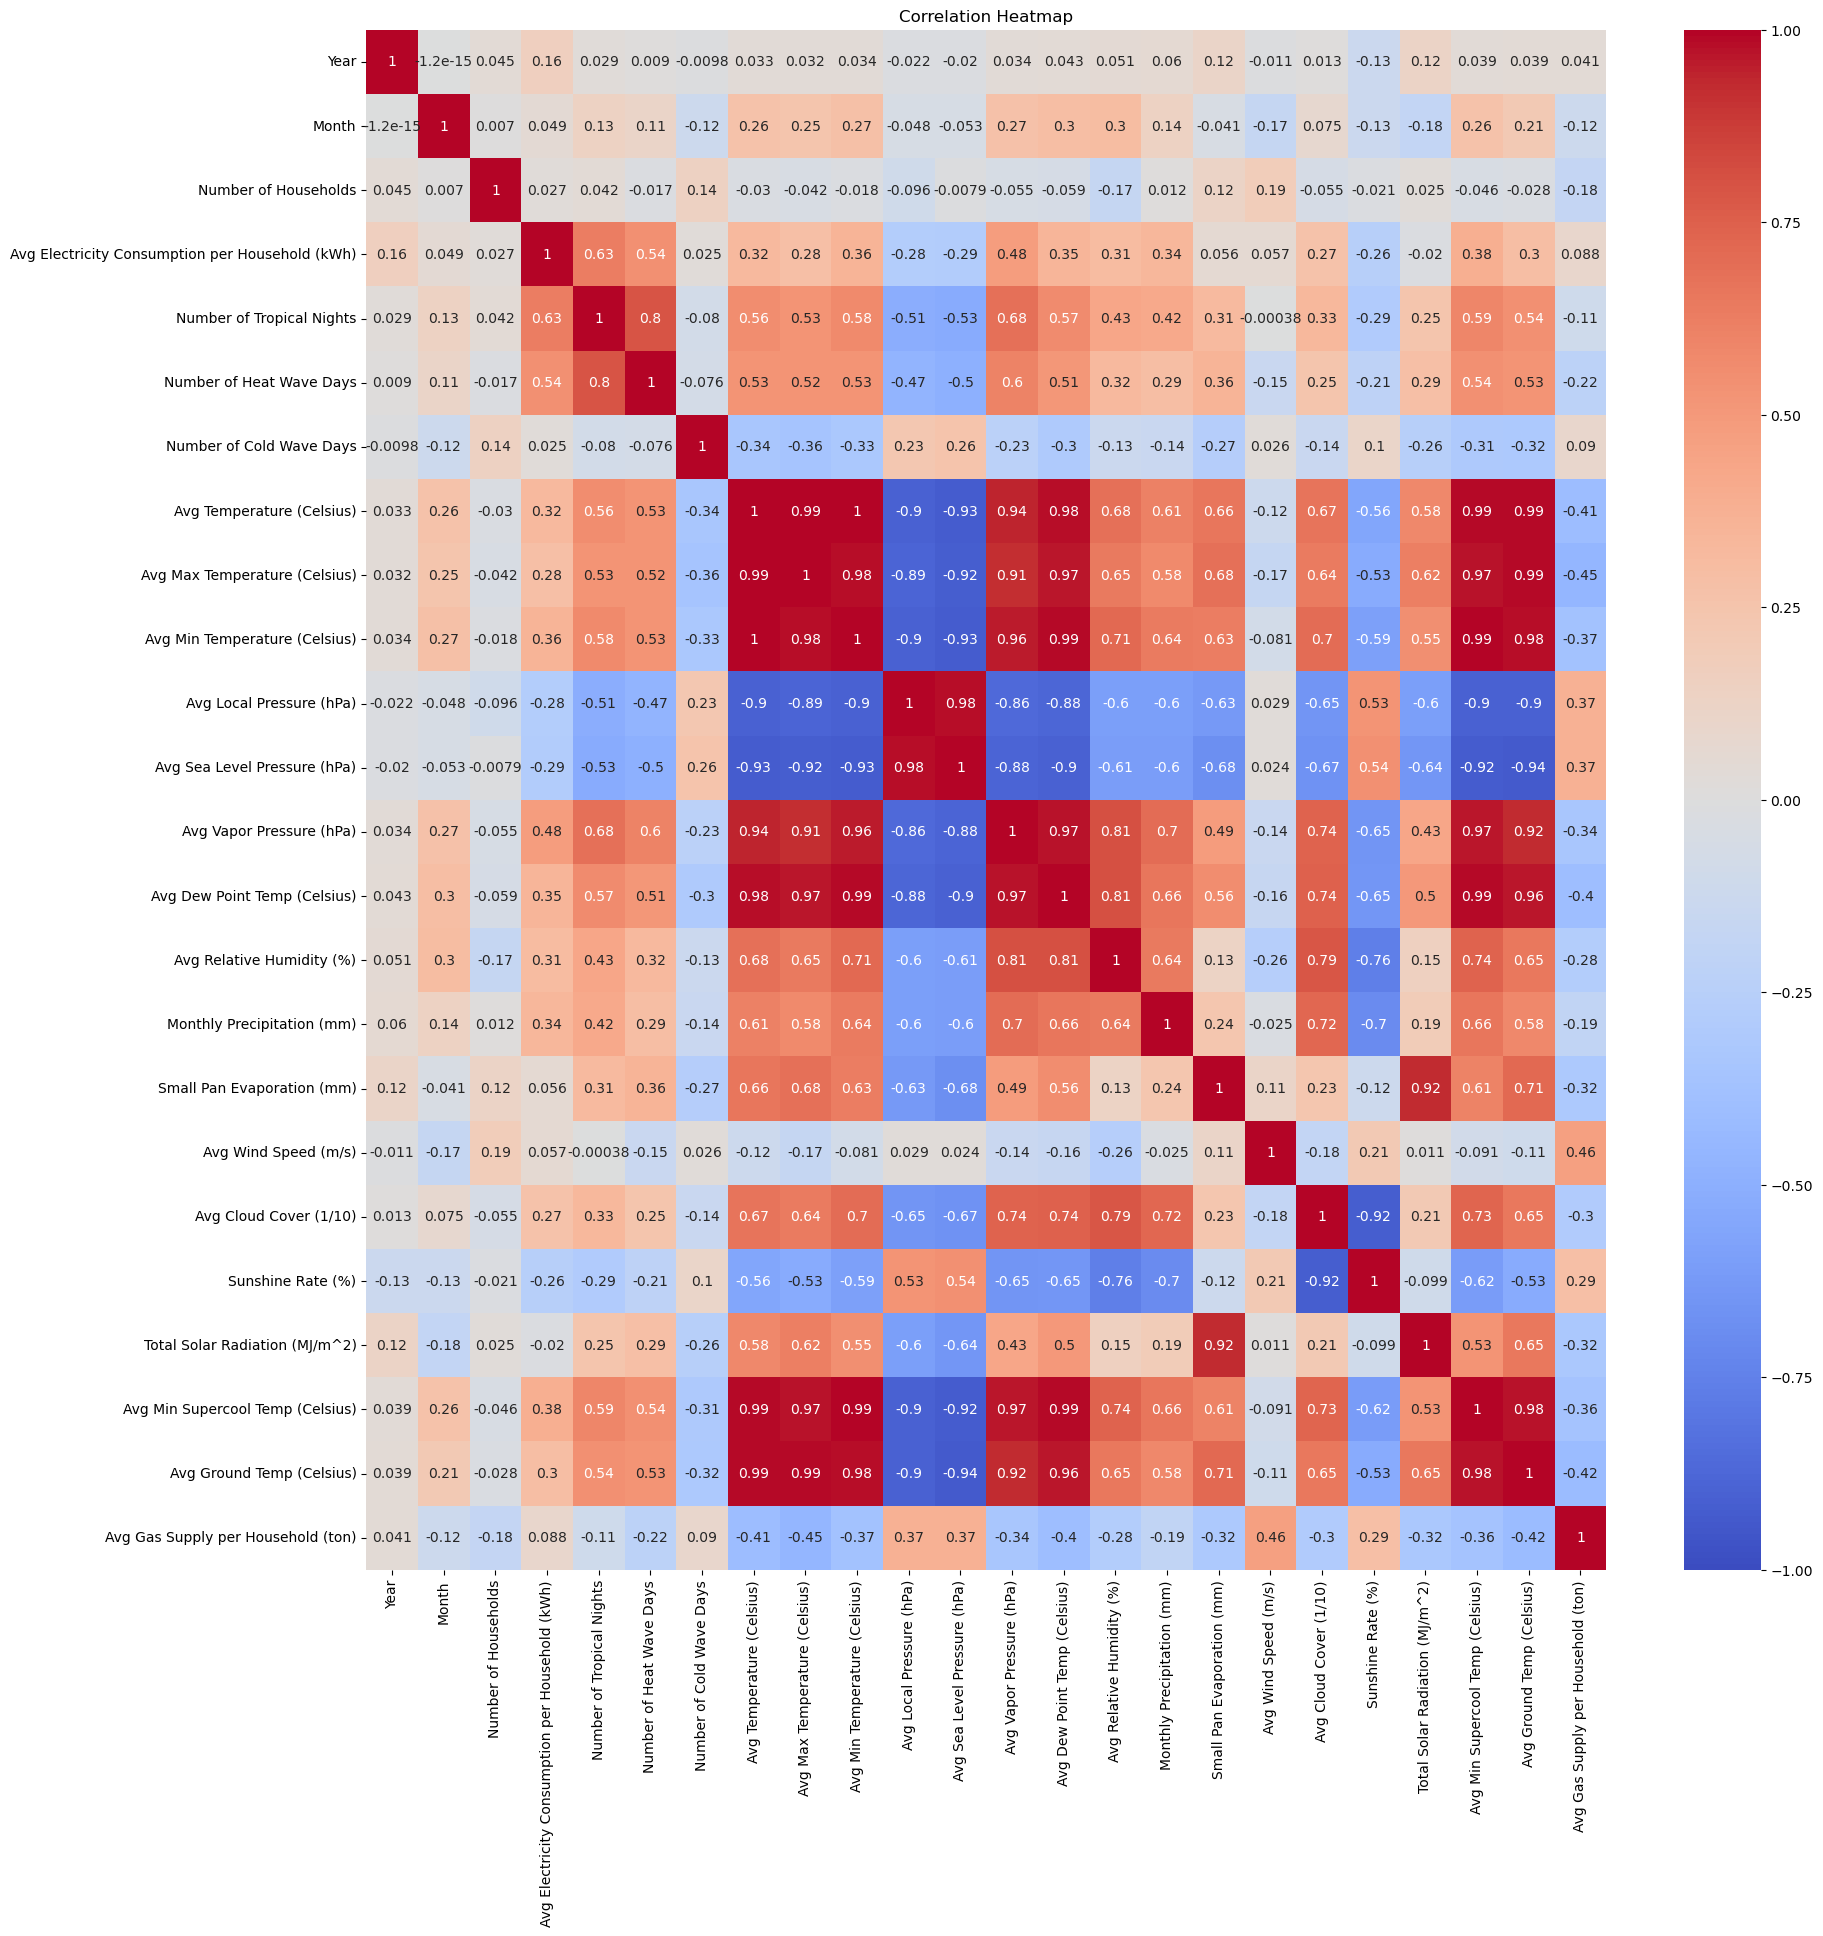

In [ ]:
# Heatmap
df_numeric=df.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Electricity Consumption per Household (kWh)'])<0.2].index
# filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

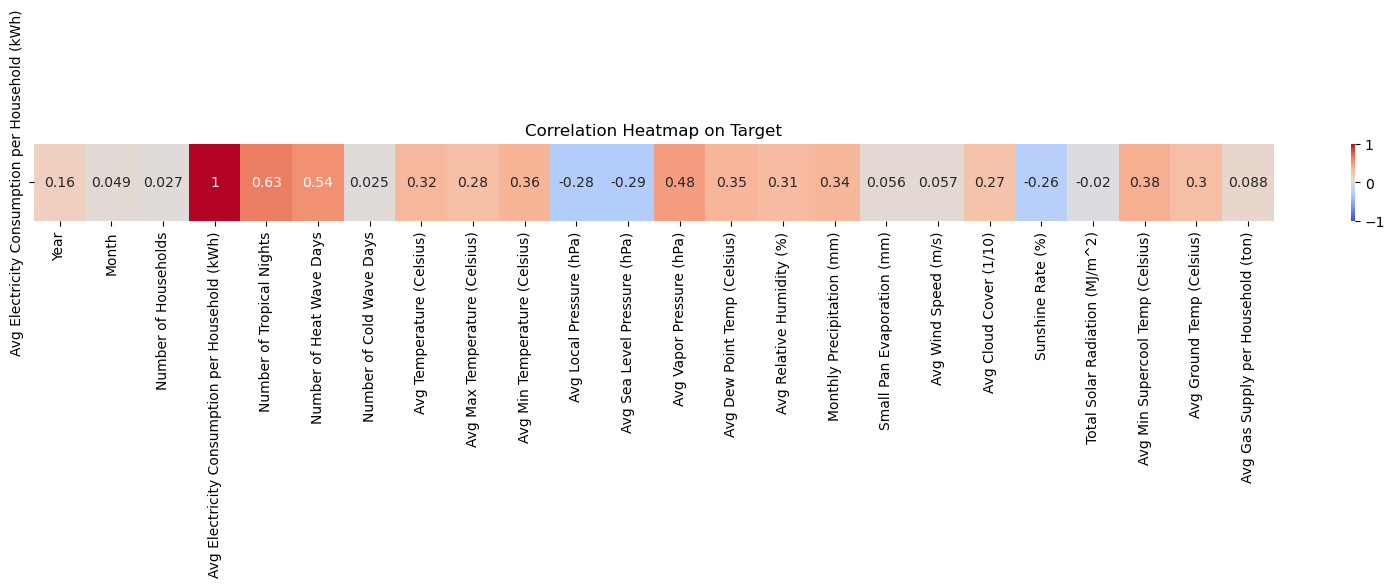

In [ ]:
# Heatmap on Avg Electricity Consumption per Household (kWh)
df_numeric = df.select_dtypes(include=['number'])
df_corr = df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Electricity Consumption per Household (kWh)'])<0.2].index
df_corr = df_corr.loc[['Avg Electricity Consumption per Household (kWh)']]
#filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20, 1))
sns.heatmap(df_corr, annot=True, vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

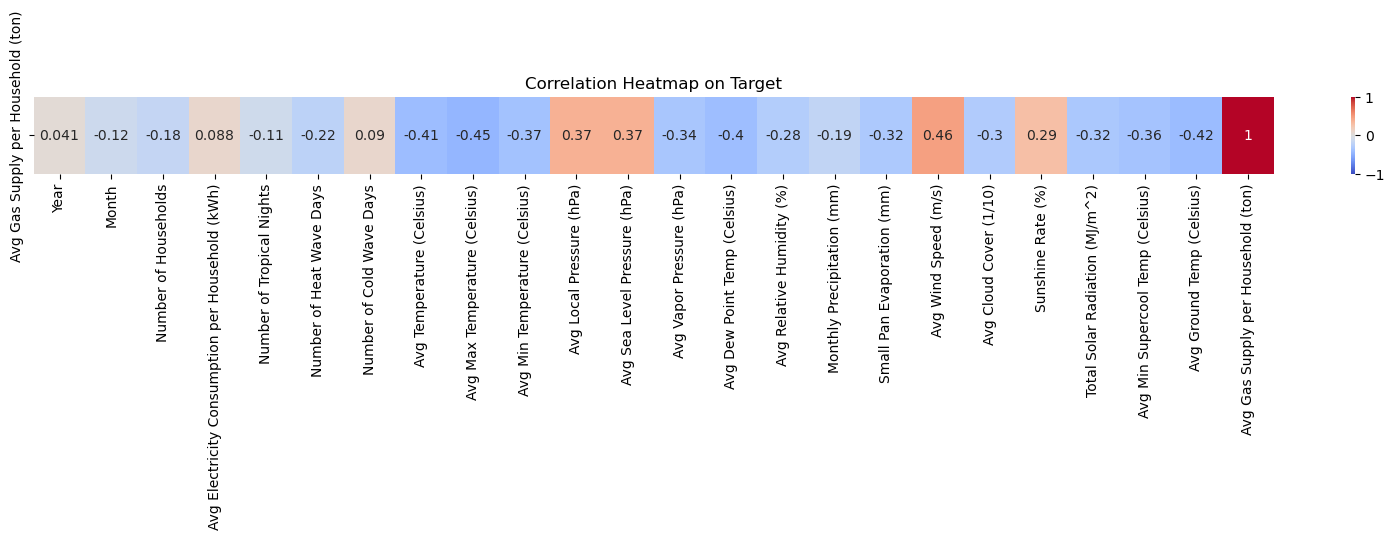

In [ ]:
# Heatmap on Avg Gas Supply per Household (ton)
df_numeric = df.select_dtypes(include=['number'])
df_corr = df_numeric.corr()
df_corr = df_corr.loc[['Avg Gas Supply per Household (ton)']]
plt.figure(figsize=(20, 1))
sns.heatmap(df_corr, annot=True, vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

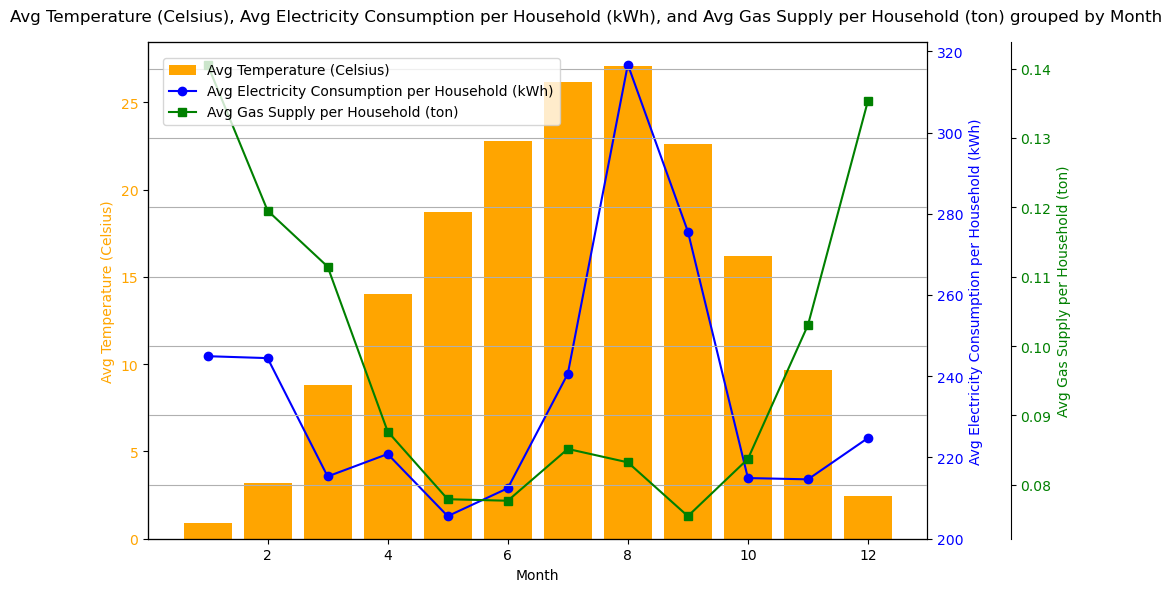

In [ ]:
# Monthly average temperature, electricity consumption and gas supply
triple_features_plot(df, 'Avg Temperature (Celsius)', 'Avg Electricity Consumption per Household (kWh)', 'Avg Gas Supply per Household (ton)', 'Month')

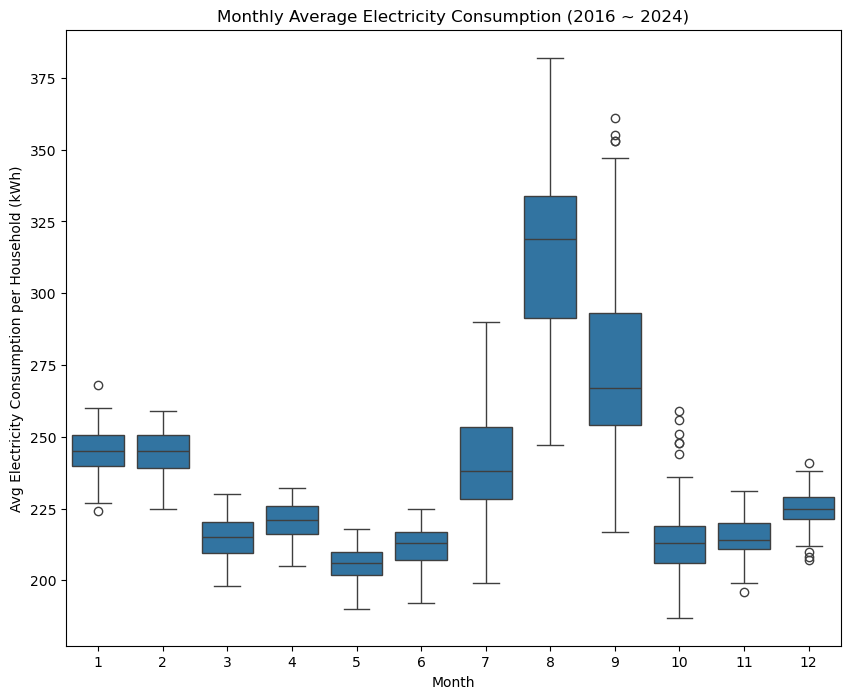

In [ ]:
# Monthly average electricity consumption box plot
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='Avg Electricity Consumption per Household (kWh)')
plt.title("Monthly Average Electricity Consumption (2016 ~ 2024)")
plt.xlabel("Month")
plt.ylabel("Avg Electricity Consumption per Household (kWh)")
plt.show()

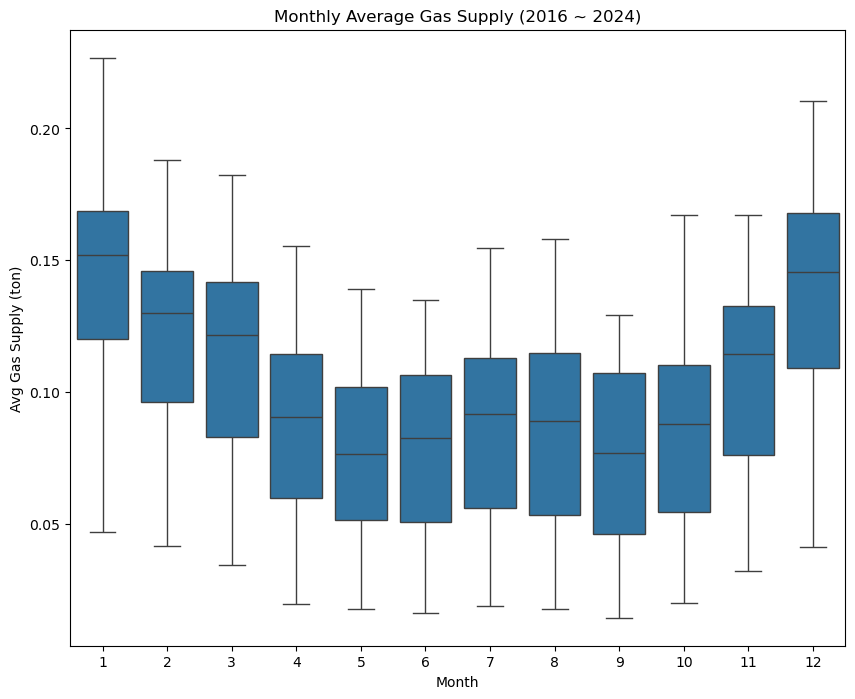

In [ ]:
# Monthly average gas supply box plot
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='Avg Gas Supply per Household (ton)')
plt.title("Monthly Average Gas Supply (2016 ~ 2024)")
plt.xlabel("Month")
plt.ylabel("Avg Gas Supply (ton)")
plt.show()

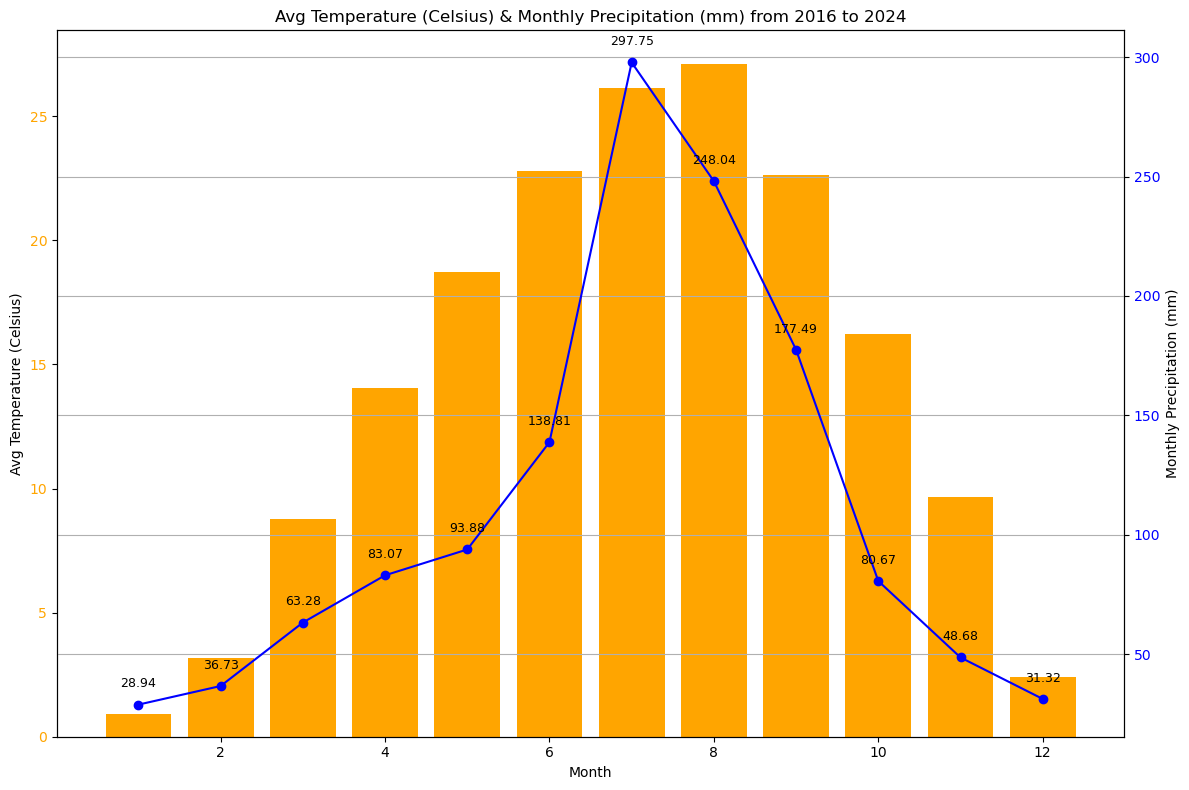

In [ ]:
# Monthly temperature and precipitation plot
dual_features_plot(a='Avg Temperature (Celsius)', b='Monthly Precipitation (mm)', c='Month')


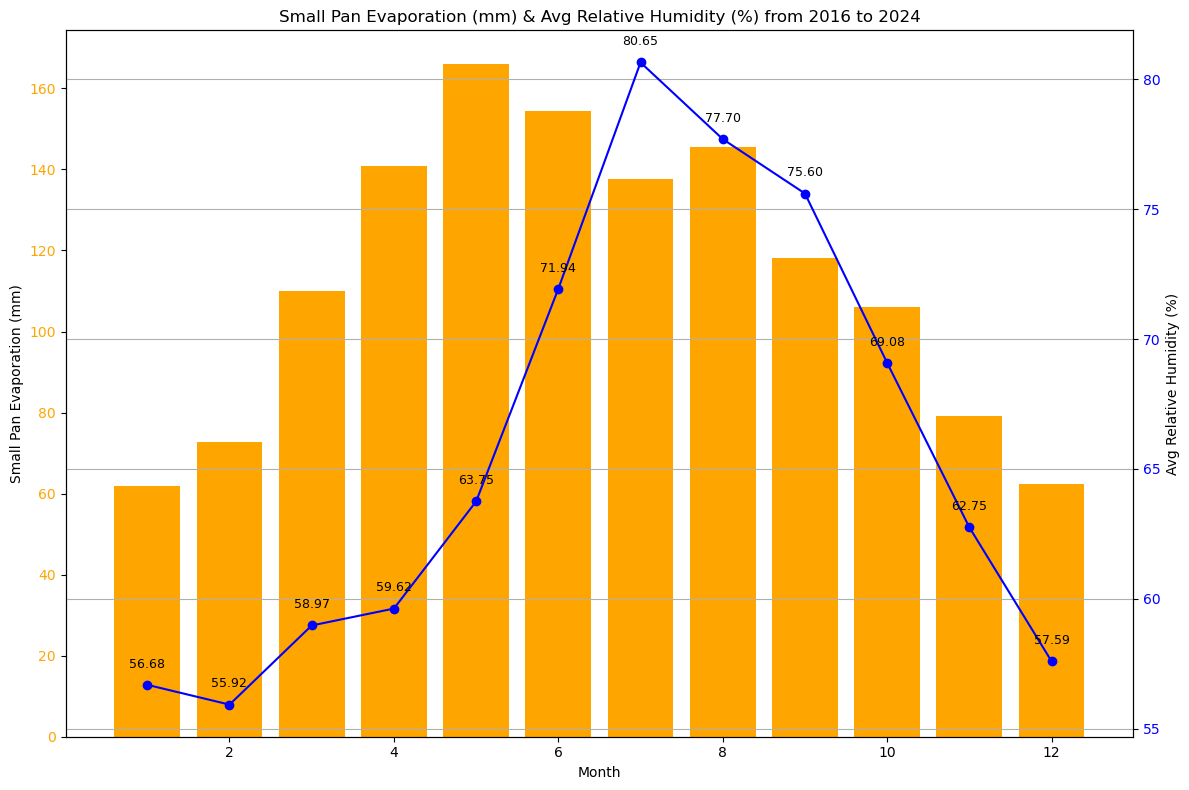

In [ ]:
# Monthly small pan evapouration and avg relative humidity
dual_features_plot(a='Small Pan Evaporation (mm)',b='Avg Relative Humidity (%)',c='Month')

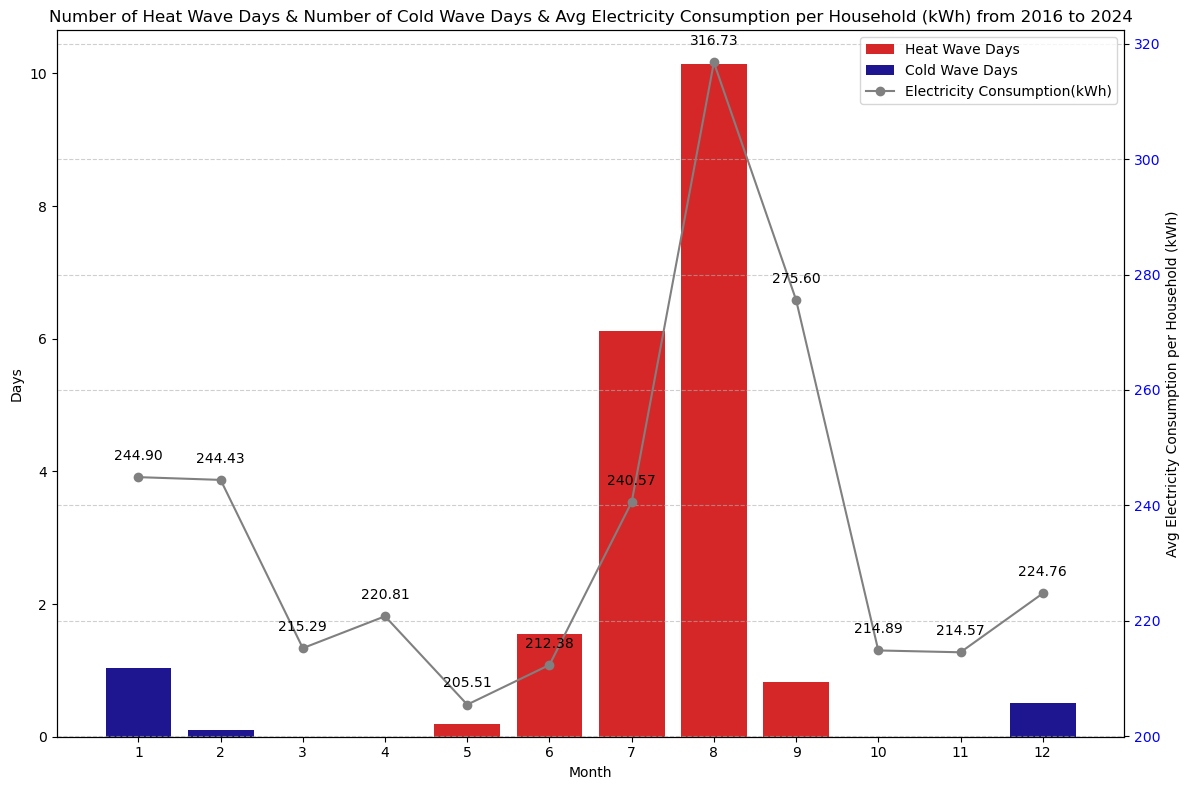

In [ ]:
# Monthly heat wave days & cold wave days & energy consumption
bar_widths = 0.5
color_a = 'tab:red'
color_b = '#1e1690'
color_c = 'tab:orange'
col_a = 'Heat Wave Days'
col_b = 'Cold Wave Days'
col_c = 'Tropical Nights'
data = df.groupby('Month')[['Number of Heat Wave Days', 'Number of Cold Wave Days','Number of Tropical Nights']].mean().reset_index()
data_mean = df.groupby('Month')[['Avg Electricity Consumption per Household (kWh)']].mean().reset_index()
fig, ax_1 = plt.subplots(figsize=(12, 8))
months = data['Month'].unique()
x = np.arange(len(months))
rects1 = ax_1.bar(data['Month'], data['Number of Heat Wave Days'],label=col_a , color=color_a)
rects2 = ax_1.bar(data['Month'],  data['Number of Cold Wave Days'],label=col_b, color=color_b)
ax_1.set_xticks(data['Month'])
ax_1.set_xlabel('Month')
ax_1.set_ylabel('Days')
ax_1.tick_params(axis='y', labelcolor='black')

#######
col_d = 'Electricity Consumption(kWh)'
ax_2 = ax_1.twinx()
ax_2.set_ylabel('Avg Electricity Consumption per Household (kWh)')
plot_c=ax_2.plot(data_mean['Month'], data_mean['Avg Electricity Consumption per Household (kWh)'], marker='o', color='grey',label=col_d )
ax_2.tick_params(axis='y', labelcolor='blue')
for x_val,y_val in zip(data_mean['Month'],data_mean['Avg Electricity Consumption per Household (kWh)']):
	ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=10,color='black')
plt.title(f'Number of Heat Wave Days & Number of Cold Wave Days & Avg Electricity Consumption per Household (kWh) from 2016 to 2024')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.tight_layout()
handles_to_combine = [rects1, rects2] + plot_c
labels_to_combine = [h.get_label() for h in handles_to_combine]
h1,l1 =ax_1.get_legend_handles_labels()
h2,l2 =ax_2.get_legend_handles_labels()
handles = h1 + h2
labels = l1 + l2
plt.legend(handles,labels,loc='best')
plt.show()

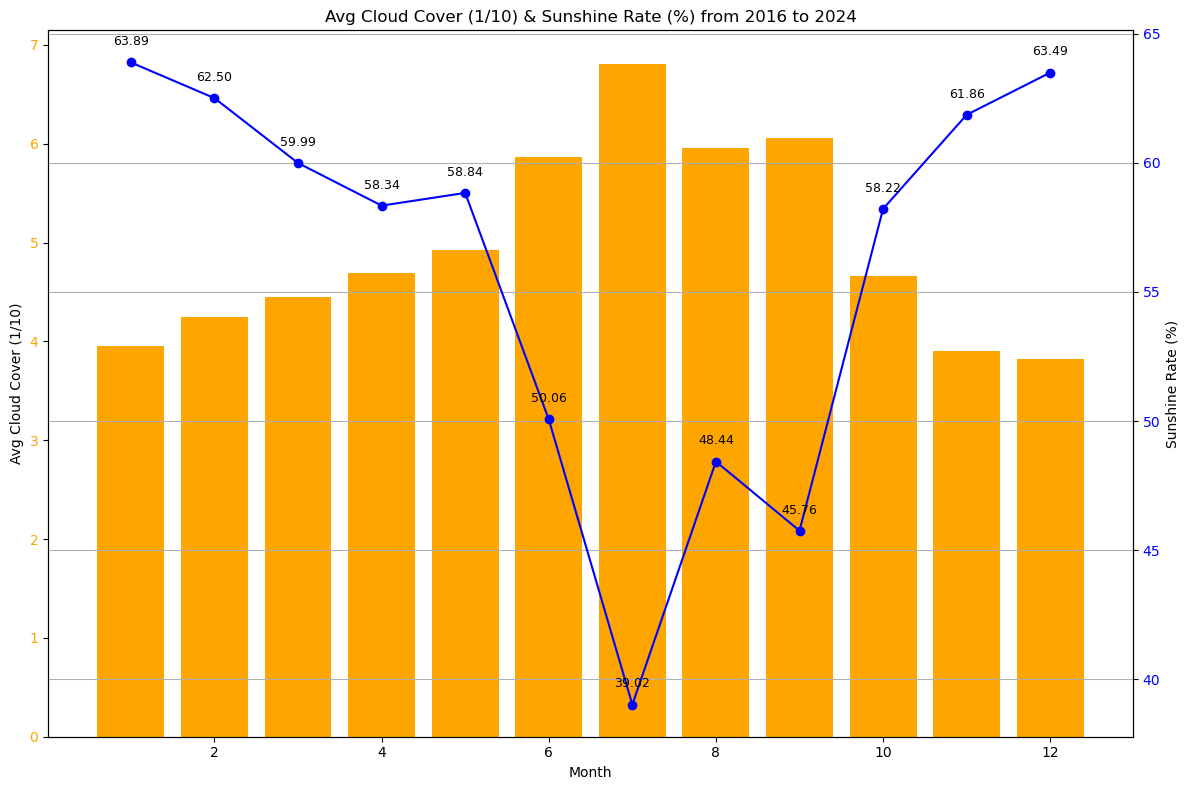

In [ ]:
# Monthly avg cloud cover and sunshine rate
dual_features_plot(a='Avg Cloud Cover (1/10)', b='Sunshine Rate (%)', c='Month')

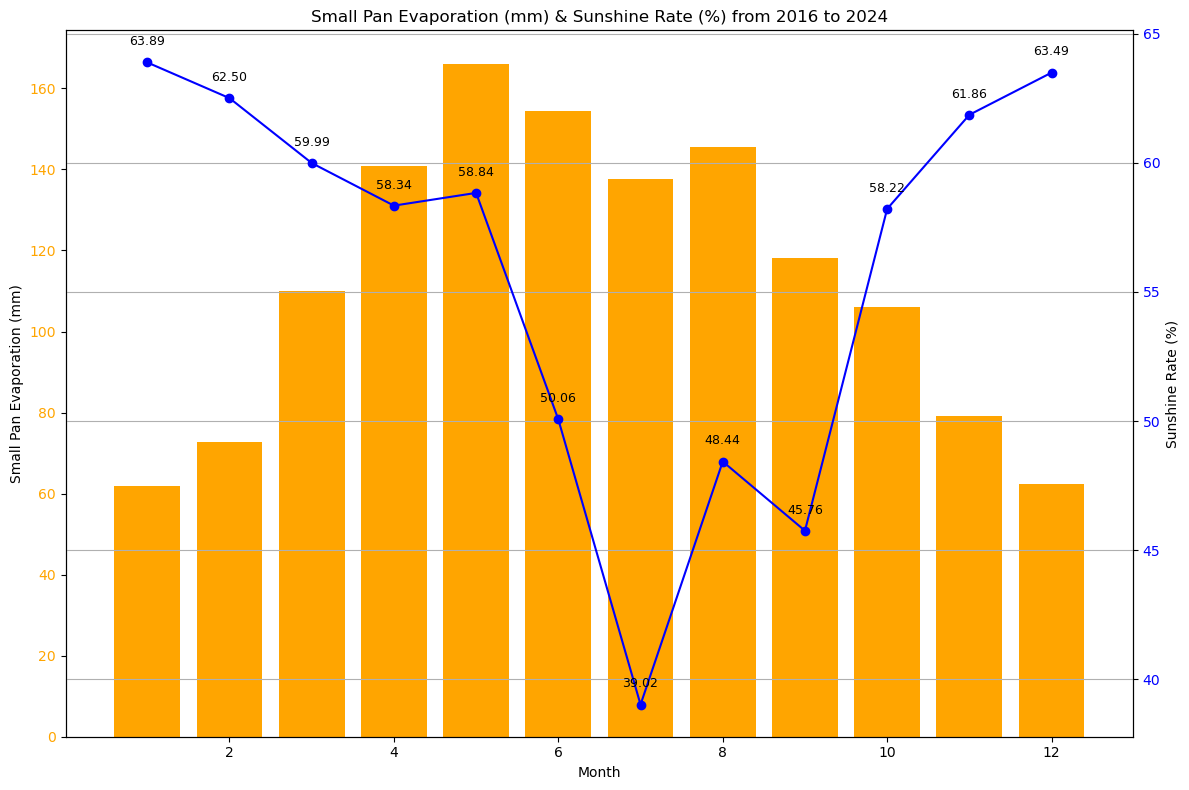

In [ ]:
#Monthly sunlight and evaporation
dual_features_plot(a='Small Pan Evaporation (mm)', b='Sunshine Rate (%)', c='Month')

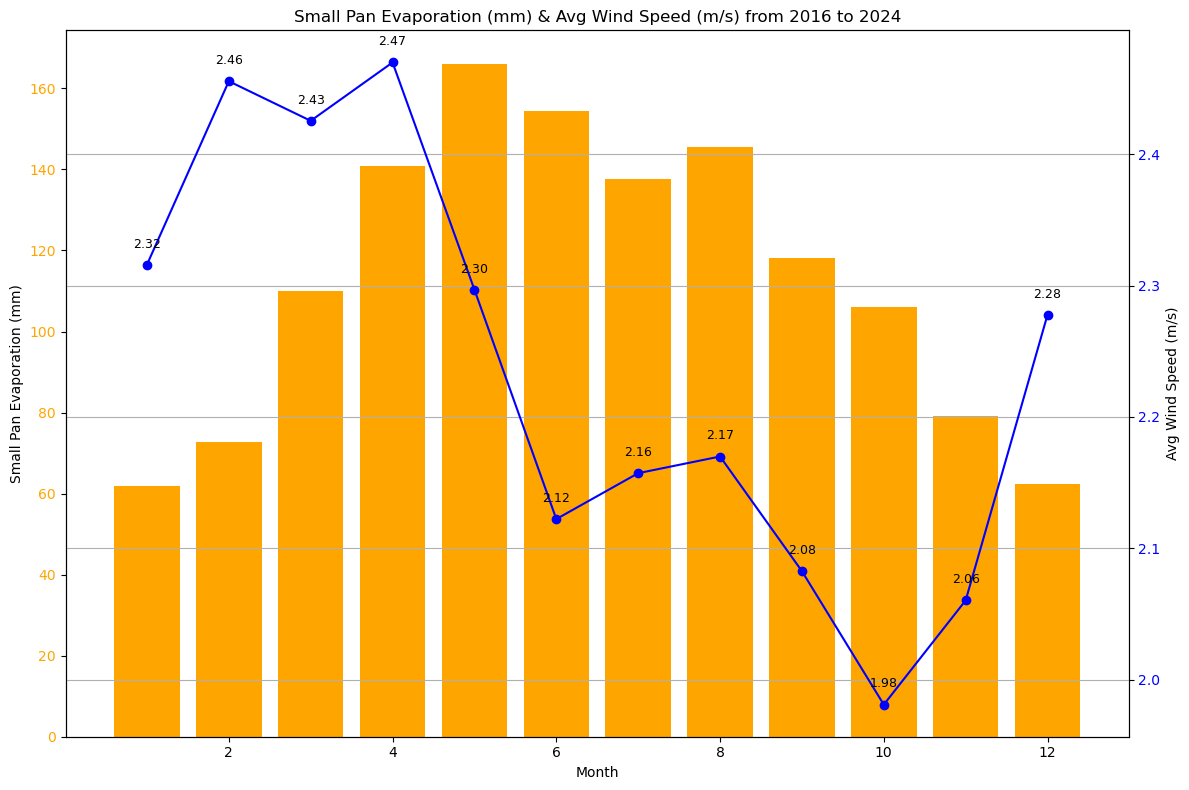

In [ ]:
#Monthly avg wind speed and small pan evapouration
dual_features_plot(a='Small Pan Evaporation (mm)', b='Avg Wind Speed (m/s)', c='Month')

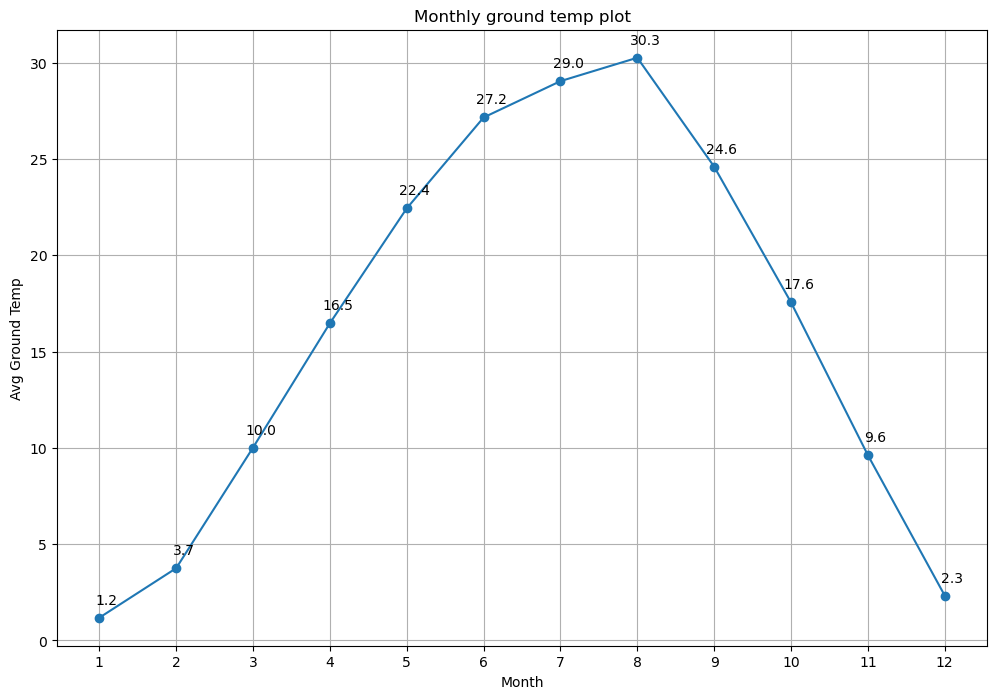

In [ ]:
# Monthly ground temp plot
df_mean=df.groupby('Month')['Avg Ground Temp (Celsius)'].mean()

plt.figure(figsize=(12, 8))
df_mean.plot(kind='line',marker='o')
plt.xticks(df_mean.index)
plt.xlabel('Month')
plt.ylabel('Avg Ground Temp')
plt.title('Monthly ground temp plot')
for x_val, y_val in df_mean.items():
	plt.text(x_val+0.1,y_val+0.55,f'{y_val:.1f}',ha='center',va='bottom',fontsize=10)
plt.grid()
plt.show()

In [ ]:
# Number of heat wave days per month by region
one_feature_two_group('Region','Month','Number of Heat Wave Days')

NameError: name 'one_feature_two_group' is not defined

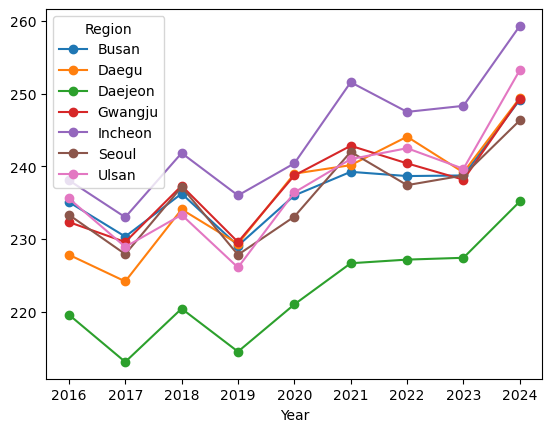

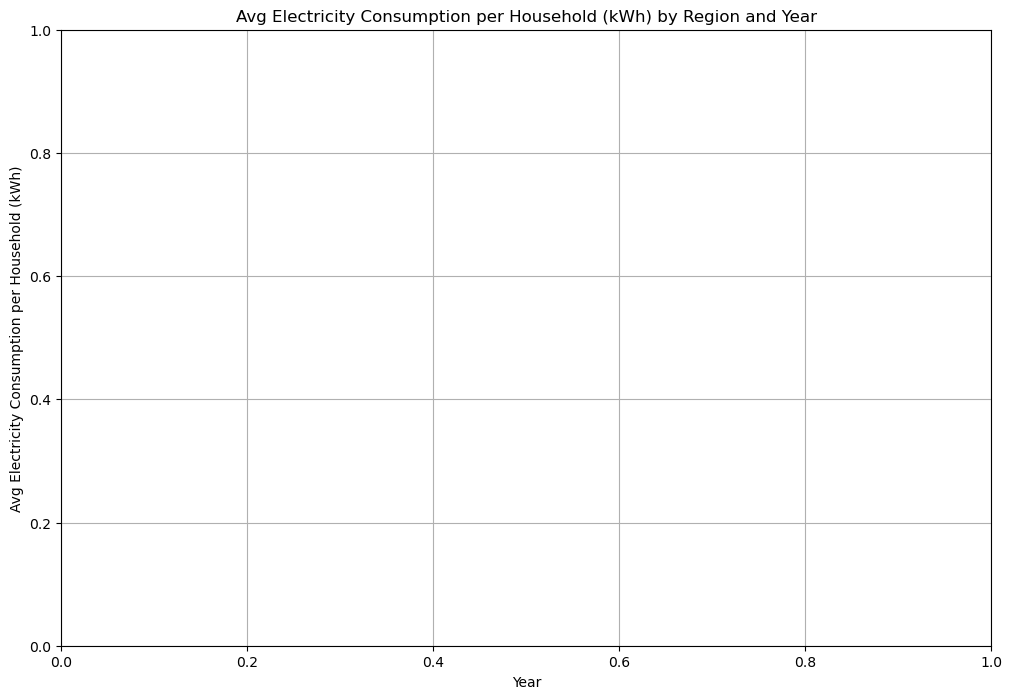

In [ ]:
# Avg electricity consumption per household (kWh) by region
one_feature_two_group('Region','Year','Avg Electricity Consumption per Household (kWh)')

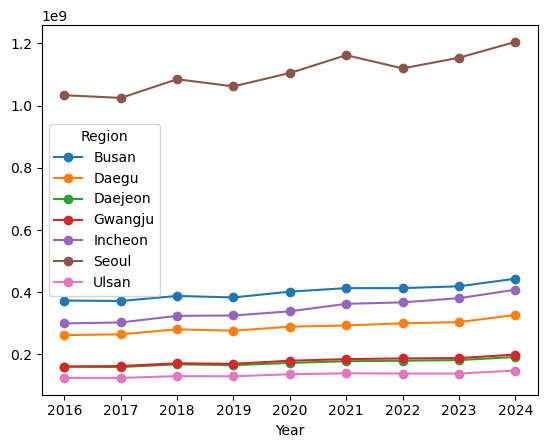

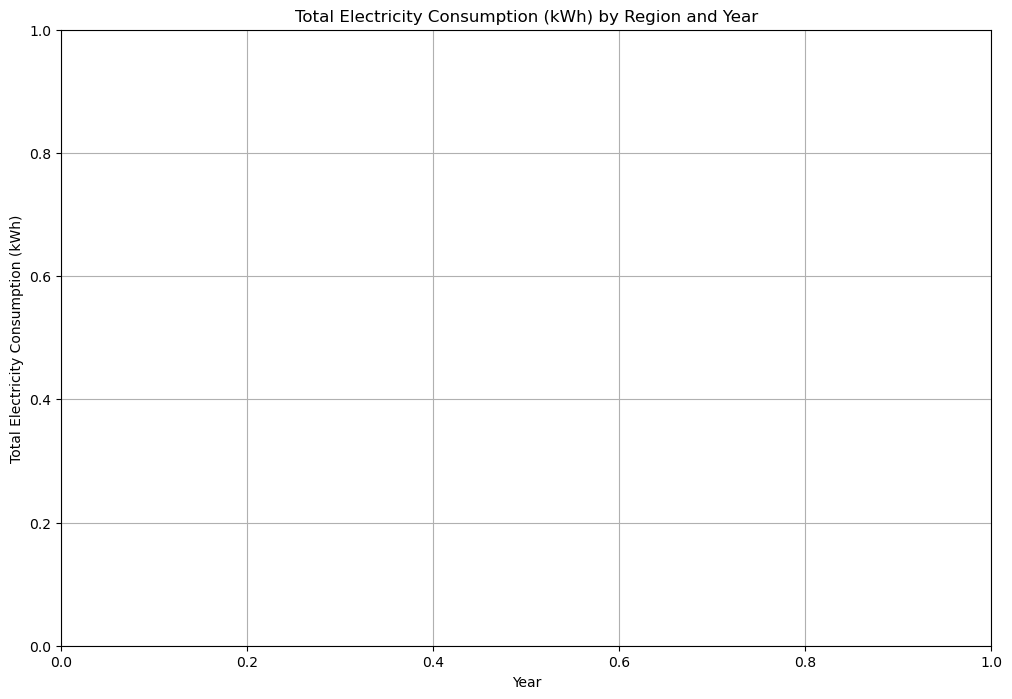

In [ ]:
# Total electricity consumption (kWh) by region
df['Total Electricity Consumption (kWh)'] = df['Number of Households'] * df['Avg Electricity Consumption per Household (kWh)']
one_feature_two_group('Region','Year','Total Electricity Consumption (kWh)')
df = df.drop(columns=['Total Electricity Consumption (kWh)'])

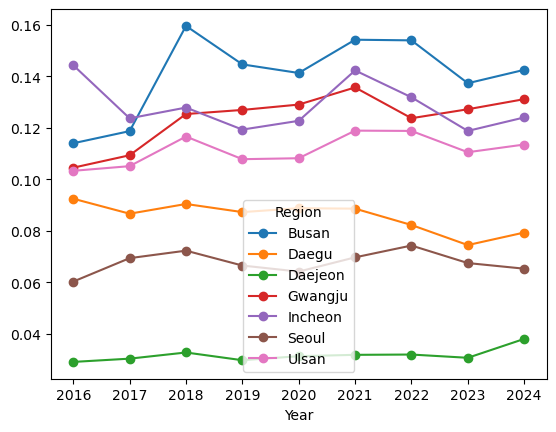

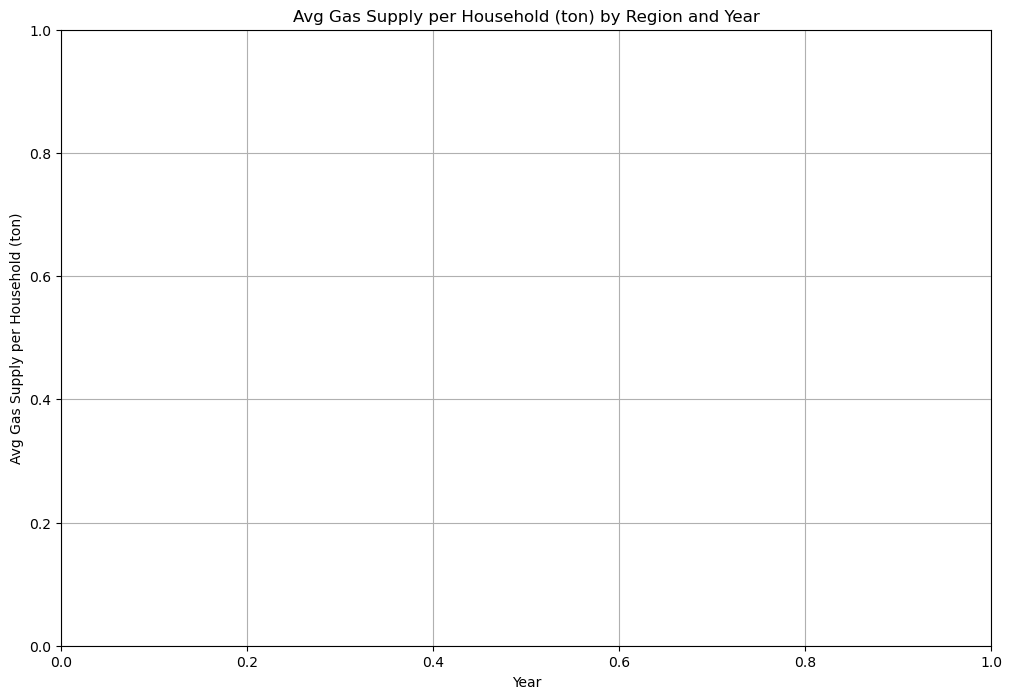

In [ ]:
# Avg Gas Supply per Household (ton) by region
one_feature_two_group('Region','Year','Avg Gas Supply per Household (ton)')

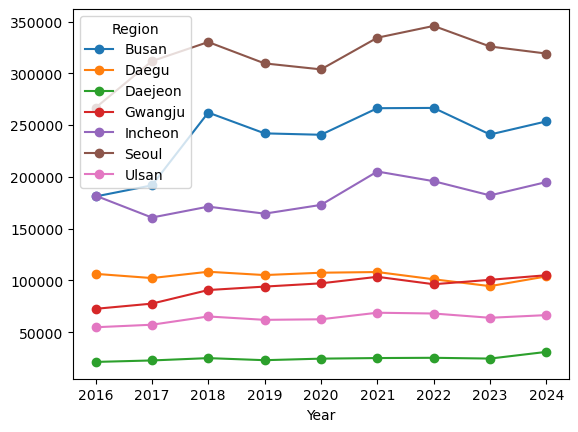

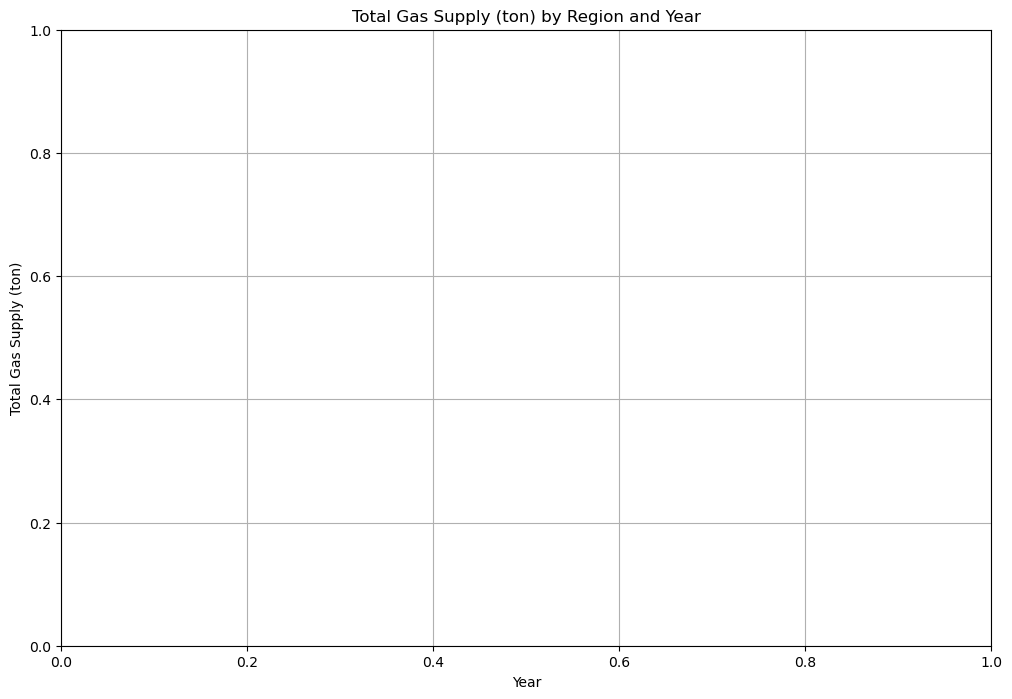

In [ ]:
# Total gas supply (ton) by region
df['Total Gas Supply (ton)'] = df['Number of Households'] * df['Avg Gas Supply per Household (ton)']
one_feature_two_group('Region','Year','Total Gas Supply (ton)')
df = df.drop(columns=['Total Gas Supply (ton)'])

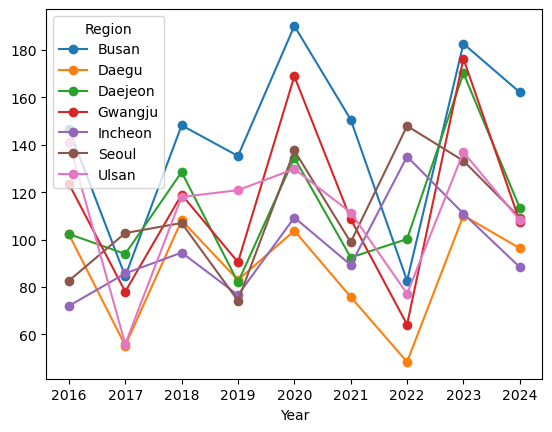

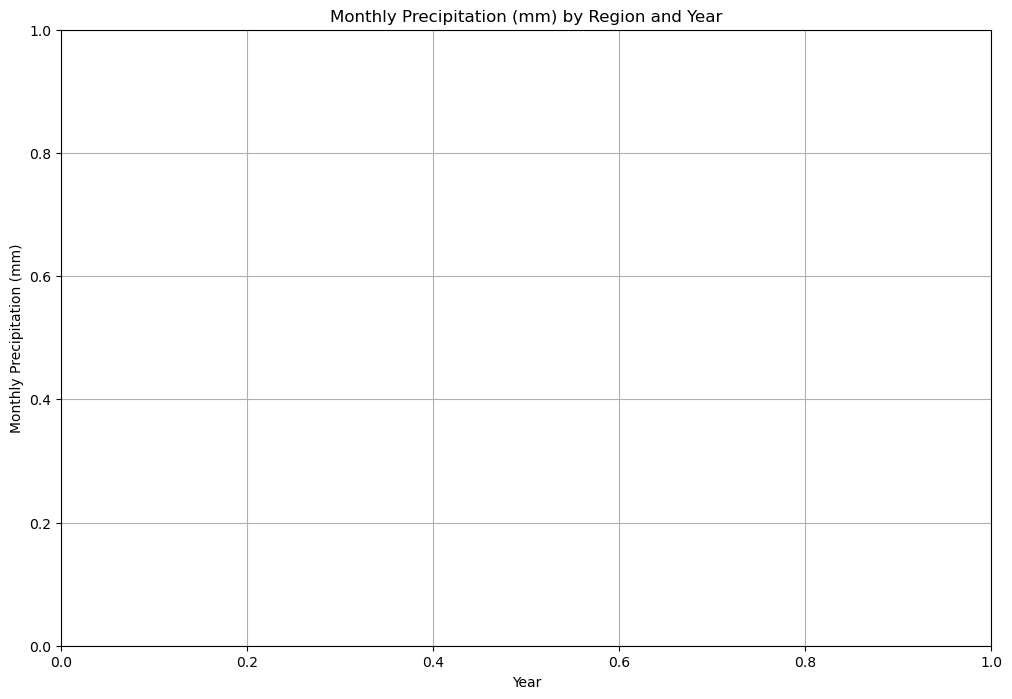

In [ ]:
# Precipitation by region
one_feature_two_group('Region','Year','Monthly Precipitation (mm)')

### **Data Preprocessing**

- Preprocessing steps safe to do before splitting
<br>

	- Remove obvious duplicates
	- Fix incorrect labels
	- Drop irrelevant columns
	- Basic data cleaning such as fixing typos or unifying units
	- Handling missing data if not based on global statistics such as dropping rows w/ missing target
	- Changing boolean type to 0 / 1
</br>

- Preprocessing steps that should happen after train-test split
<br>
	- Feature scaling / Normalisation
	- Encoding categorical variables
	- Dimensionality reduction
	- Outlier detection (if model is sensitive)
	- Feature selection based on correlation or variance
	- Creating time-based features if it involves future data
	- Data augmentation
</br>

In [384]:
def stepwise_selection(X, y,
					   initial_list=[],
					   threshold_in=0.05,
					   threshold_out=0.10,
					   verbose=True):
	"""
	Perform a stepwise feature selection based on p-values from statsmodels OLS.

	Parameters:
	- X : pd.DataFrame
		Candidate feature set (independent variables).
	- y : pd.Series or np.array
		Target variable (dependent variable).
	- initial_list : list
		Initial list of features to start the selection process.
	- threshold_in : float
		p-value threshold for adding a feature (smaller = more strict).
	- threshold_out : float
		p-value threshold for removing a feature (larger = more lenient).
	- verbose : bool
		Whether to print progress during feature selection.

	Returns:
	- included : list
		The final list of selected features.
	"""

	included = list(initial_list)  # Start with an initial list (could be empty)

	while True:
		changed = False  # Flag to track whether any feature was added or removed in the current iteration; If not, the loop will break

		# --- Forward Step ---
		# Try adding each feature not yet included and check p-values
		excluded = list(set(X.columns) - set(included))  # Compute the list of features not yet included in the model; These are the candidates for addition
		new_pval = pd.Series(index=excluded, dtype=float)  # Initialise a Series to store the p-values of each excluded feature if it were to be added to the model
		for new_column in excluded: # Iterate over all excluded features to assess their contribution
			# Fit OLS model with the current included features + this new one
			X_with_const = sm.add_constant(X[included + [new_column]]) # Prepare the design matrix with a constant term (intercept) and the current included features plus the candidate new feature
			model = sm.OLS(y, X_with_const).fit() # Fits an Ordinary Least Squares (OLS) linear regression model to the current design matrix
			new_pval[new_column] = model.pvalues[new_column]  # Extract the p-value of the newly added feature and stores it

		# Add the feature with the lowest p-value if it's below threshold_in
		if not new_pval.empty and new_pval.min() < threshold_in: # Check whether the smallest p-value among the excluded features is statistically significant, i.e., below the inclusion threshold
			best_pval = new_pval.idxmin()  # Feature with the smallest p-value
			included.append(best_pval)
			changed = True
			if verbose:
				print(f'Add {best_pval} with p-value {new_pval.min():.6f}')

		# --- Backward Step ---
		# Now check if any included feature should be removed
		X_with_const = sm.add_constant(X[included])
		model = sm.OLS(y, X_with_const).fit() # Re-fit the model using the current set of included features to re-calculate all p-values
		pvalues = model.pvalues.iloc[1:]  # Get p-values for all features excluding the intercept (which is the first value); These are the features being evaluated for possible removal

		# If any included feature has a p-value above threshold_out, remove the worst one
		if not pvalues.empty and pvalues.max() > threshold_out: # If the worst (largest) p-value among included features exceeds the exclusion threshold, it’s a candidate for removal
			worst_pval = pvalues.idxmax() # Find the feature with the worst (largest) p-value
			included.remove(worst_pval) # Remove this feature from the model
			changed = True
			if verbose:
				print(f'Drop {worst_pval} with p-value {pvalues.max():.6f}')

		# If no feature was added or removed, the process is done
		if not changed:
			break

	# Print final selected features and summary
	if verbose:
		print("\nFinal Selected Variables:")
		print(included)
		final_X_with_const = sm.add_constant(X[included])
		final_model = sm.OLS(y, final_X_with_const).fit()
		print("\nFinal Model Summary:")
		print(final_model.summary())

	return included

In [507]:
def correlation_col(X: pd.DataFrame, Y: pd.Series, feature: str, threshold: float):
	"""
	Identify numeric columns that are weakly correlated with a specified feature.

	Parameters:
	- X (pd.DataFrame): Feature dataset.
	- Y (pd.Series): Target variable to be appended for correlation analysis.
	- feature (str): The column name to compare correlations against.
	- threshold (float): Absolute correlation threshold; columns with correlation
						 less than this value will be returned.

	Returns:
	- pd.Index: Column names with absolute correlation to the specified feature
				less than the given threshold.
	"""
	df = pd.concat([X, Y], axis=1)
	df_numeric = df.select_dtypes(include=['number'])
	df_corr = df_numeric.corr()
	corr_low_cols = df_corr[abs(df_corr[feature]) < threshold].index

	return corr_low_cols

In [500]:
# Data split for features and target
X = df.drop(columns=['Avg Electricity Consumption per Household (kWh)', 'Avg Gas Supply per Household (ton)'])
y = df['Avg Electricity Consumption per Household (kWh)']
# y = df['Avg Gas Supply per Household (ton)']

In [501]:
# Grab column names of each data type
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
datetime_cols = X.select_dtypes(include=['datetime']).columns

In [502]:
# Data split for train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [503]:
# X4 - Stepwise selection (Run before the region one hot encoding)
stepwise_cols = stepwise_selection(X_train.select_dtypes(include=['number']), y_train, threshold_in=0.01, threshold_out=0.01, verbose=False)
X4_train = X_train[stepwise_cols]
X4_test = X_test[stepwise_cols]

# Scaling
scaler = StandardScaler()
X4_train.loc[:, stepwise_cols] = scaler.fit_transform(X4_train[stepwise_cols])
X4_test.loc[:, stepwise_cols] = scaler.transform(X4_test[stepwise_cols])

# Region one hot encoding
X4_train = pd.concat([X4_train, X_train['Region']], axis=1)
X4_test = pd.concat([X4_test, X_test['Region']], axis=1)
X4_train = pd.get_dummies(data=X4_train, columns=['Region'], dtype=int)
X4_test = pd.get_dummies(data=X4_test, columns=['Region'], dtype=int)



<ipython-input-503-e519108acf3e>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.75655816  0.36798577 -1.57487617 -1.18630378 -0.409159    0.36798577
  0.75655816  0.75655816  1.14513055 -0.02058662 -0.79773139 -0.79773139
 -0.79773139 -0.02058662  1.53370294 -0.79773139 -0.79773139 -0.02058662
 -0.409159   -1.57487617 -1.18630378  0.75655816 -0.409159    1.14513055
 -0.409159   -0.409159   -1.18630378 -0.79773139 -1.57487617  0.36798577
 -0.02058662 -0.409159   -0.409159   -1.57487617  1.14513055 -0.02058662
  1.53370294 -0.02058662 -0.409159   -0.409159    0.75655816 -0.79773139
  0.75655816 -1.18630378  1.14513055  0.36798577 -1.18630378 -1.57487617
  0.75655816 -0.02058662  1.14513055  0.36798577  1.53370294  1.53370294
  0.75655816  1.14513055  0.36798577 -0.79773139 -1.18630378  1.14513055
 -1.18630378 -1.18630378 -0.79773139  0.36798577  0.75655816  0.75655816
  0.36798577 -1.18630378 -1.18630378 -0.797

In [504]:
# Region label encoding
# label_encoder = LabelEncoder()
# for col in categorical_cols:
#     X_train[col] = label_encoder.fit_transform(X_train[col])
#     X_test[col] = label_encoder.transform(X_test[col])

# Region one hot encoding
X_train = pd.get_dummies(data=X_train, columns=['Region'], dtype=int)
X_test = pd.get_dummies(data=X_test, columns=['Region'], dtype=int)


# Scaling
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [505]:
# X0 - All
X0_train = X_train.copy()
X0_test = X_test.copy()

In [508]:
# X1 - Correlation
corr_low_cols = correlation_col(X_train, y_train,'Avg Electricity Consumption per Household (kWh)', 0.2)
print(corr_low_cols)
X1_train = X_train.drop(columns=(corr_low_cols))
X1_test = X_test.drop(columns=(corr_low_cols))

Index(['Year', 'Month', 'Number of Households', 'Number of Cold Wave Days',
       'Small Pan Evaporation (mm)', 'Avg Wind Speed (m/s)',
       'Total Solar Radiation (MJ/m^2)', 'Region_Busan', 'Region_Daegu',
       'Region_Daejeon', 'Region_Gwangju', 'Region_Incheon', 'Region_Seoul',
       'Region_Ulsan'],
      dtype='object')


In [509]:
# X2 - PCA
pca = PCA()
pca.fit_transform(X_train)

# Find the features that contributes the most to PC 1
weights_pca = abs(pca.components_)
top_pc1_idx = np.argsort(weights_pca[0])[::-1][:15]
top_pc1_name = [X_train.columns[i] for i in top_pc1_idx]

# Grab features that contribute to PC 1
top_features = list(set(top_pc1_name))
pca_corr = X_train[top_features].corrwith(y_train)
pca_corr

# Drop columns w/ low contributions to PC 1
X2_train = X_train[top_features]
X2_test = X_test[top_features]

In [510]:
# X3 - VIF
df_vif = pd.DataFrame()
df_vif['feature'] = X_train.columns
df_vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif

vif_cols = df_vif[df_vif['VIF'] > 100]['feature']
X3_train = X_train.drop(columns=vif_cols)
X3_test = X_test.drop(columns=vif_cols)

In [ ]:


# #######################
# # vif_col 중 실제 X_train 컬럼에 존재하는 것만 선택
# drop_cols = [col for col in vif_cols if col in X_train.columns]

# # 존재하는 컬럼만 drop
# X4_train = X_train.drop(columns=drop_cols)
# X4_test = X_test.drop(columns=drop_cols)

# # stepwise 컬럼 중 실제 X_train에 있는 컬럼만 필터링
# valid_stepwise = [col for col in stepwise if col in X_train.columns]
############################

### **Modelling**

In [177]:
def adj_r2_score(y_true: pd.Series, y_pred: pd.Series, X_features: pd.DataFrame) -> float:
	"""
	Compute the adjusted R² (coefficient of determination).

	Adjusted R² adjusts the regular R² score for the number of predictors (features)
	in the model. It penalizes the R² score for adding unnecessary predictors, helping
	to avoid overfitting.

	Parameters:
	- y_true : array-like of shape (n_samples,)
		True target values.
	- y_pred : array-like of shape (n_samples,)
		Predicted target values from the model.
	- X_features : array-like of shape (n_samples, n_features)
		Data used for getting the number of predictors (features) used in the model.

	Returns:
	- adj_r2 : float
		The adjusted R-squared score. Returns NaN if the number of predictors is too large
		for the formula to be valid (i.e., n <= p + 1).
	"""
	n = len(y_true)
	p = X_features.shape[1]

	# Prevent division by zero or negative denominator
	if n <= p + 1:
		warnings.warn("Adjust R^2 is undefined.")
		return float('nan')

	return 1 - (1 - r2_score(y_true, y_pred)) * (n - 1) / (n - p - 1)

In [ ]:
def evaluate_model(model: BaseEstimator,
				   X_train: pd.DataFrame,
				   X_test: pd.DataFrame,
				   y_train: pd.Series,
				   y_test: pd.Series) -> Tuple[pd.Series, float, float, float, float]:
	"""
	Train a regression model and evaluates its performance on the test set.

	Parameters:
		model (BaseEstimator): The regression model to train (already instantiated, e.g., from GridSearchCV.best_estimator_).
		X_train (pd.DataFrame): Training features.
		X_test (pd.DataFrame): Testing features.
		y_train (pd.Series): Training target values.
		y_test (pd.Series): Testing target values.

	Returns:
		Tuple containing:
			- y_pred (pd.Series): Predicted target values on the test set.
			- mae (float): Mean Absolute Error.
			- rmse (float): Root Mean Squared Error.
			- r2 (float): R-squared score.
			- adj_r2 (float): Adjusted R-squared score.
	"""
	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)
	mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
	mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
	rmse = math.sqrt(mse)
	r2 = r2_score(y_true=y_test, y_pred=y_pred)
	adj_r2 = adj_r2_score(y_true=y_test, y_pred=y_pred, X_features=X_test)

	return y_pred, mae, rmse, r2, adj_r2

In [ ]:
def record_results(data_idx, model_name, hyperparams, training_time, y_test, y_pred, metrics):
	mae, rmse, r2, adj_r2 = metrics
	return pd.DataFrame({'Data number': [data_idx],
						 'Model': [model_name],
						 'Best hyperparameters': [[hyperparams]],
						 'Training time': [training_time],
						 'y_test': [y_test],
						 'y_pred': [y_pred],
						 'MAE': [mae],
						 'RMSE': [rmse],
						 'R^2': [r2],
						 'Adjusted R^2': [adj_r2]})

In [496]:
help(AdaBoostRegressor)

Help on class AdaBoostRegressor in module sklearn.ensemble._weight_boosting:

class AdaBoostRegressor(sklearn.utils._metadata_requests._RoutingNotSupportedMixin, sklearn.base.RegressorMixin, BaseWeightBoosting)
 |  AdaBoostRegressor(estimator=None, *, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)
 |  
 |  An AdaBoost regressor.
 |  
 |  An AdaBoost [1] regressor is a meta-estimator that begins by fitting a
 |  regressor on the original dataset and then fits additional copies of the
 |  regressor on the same dataset but where the weights of instances are
 |  adjusted according to the error of the current prediction. As such,
 |  subsequent regressors focus more on difficult cases.
 |  
 |  This class implements the algorithm known as AdaBoost.R2 [2].
 |  
 |  Read more in the :ref:`User Guide <adaboost>`.
 |  
 |  .. versionadded:: 0.14
 |  
 |  Parameters
 |  ----------
 |  estimator : object, default=None
 |      The base estimator from which the boosted ensemb

In [511]:
# Config setting
# Linear regression
model_linear_regression = LinearRegression()
hyperparams_linear_regression = {'fit_intercept': [True]}
config_linear_regression = [model_linear_regression, hyperparams_linear_regression]

# Elastic net
model_en = ElasticNet(random_state=42)
hyperparams_en = {'alpha': [0.1, 1, 10],
				  'l1_ratio': [0.1, 0.5, 0.9]}
config_en = [model_en, hyperparams_en]

# SVR
model_svr = SVR()
hyperparams_svr = {'kernel': ['poly', 'rbf', 'sigmoid'],
				   'C':[10, 100, 1000],
				   'epsilon':[0.3,0.5,0.8]}
config_svr = [model_svr, hyperparams_svr]

# Decision tree
model_dt = DecisionTreeRegressor(random_state=42)
hyperparams_dt = {'criterion': ['absolute_error', 'squared_error'],
								'max_depth': [3, 5, 7, 10, None],
								'min_samples_split': [2, 5, 10],
								'min_samples_leaf': [1, 2, 4],
								'max_features': ['sqrt', 'log2', None]}
config_dt = [model_dt, hyperparams_dt]

# Random forest
model_rf = RandomForestRegressor(random_state=42)
hyperparams_rf={'n_estimators': [10, 50, 100],
				'max_depth': [None, 10, 20],
				'min_samples_split': [2, 5, 10],
				'min_samples_leaf': [1, 2, 4],
				'bootstrap': [True, False],}
config_rf = [model_rf, hyperparams_rf]

# AdaBoost
model_ada = AdaBoostRegressor(random_state=42)
hyperparams_ada = {'n_estimators': [30, 50, 100,200,300,400,500,600],
				   'learning_rate': [0.1,0.5,0.05,0.01, 0.005, 0.001]}
config_ada = [model_ada, hyperparams_ada]

# XGB
model_xgb=XGBRegressor(random_state=42)
hyperparams_xgb={'n_estimators': [100, 200, 300],
				 'learning_rate': [0.01, 0.05, 0.1],
				 'max_depth': [3, 5, 7]}
config_xgb = [model_xgb, hyperparams_xgb]

In [512]:
from sklearn.inspection import permutation_importance

In [514]:
#GridSearch 모델에 들어갈
models = [ config_ada]
# models = [config_en, config_svr, config_dt, config_ada, config_xgb]
num=0
n=0
#X_trains,X_tests는 Feature Selection 그룹
X_trains=[X0_train, X1_train, X2_train, X3_train, X4_train]
X_tests=[X0_test, X1_test, X2_test, X3_test, X4_test]


for X_train, X_test in zip(X_trains,X_tests):
    #DF에 들어갈 특성그룹 번호
    Data_num='X'+str(num+1)
    #현재 돌아가고 있는 위치
    print(num)
    for i in range(len(models)):
        #현재 돌아가고있는 위치 2
        print(n)
        #Model-> 모델 선언 ex)SVR(),XGBRegressor()
        Model=models[i][0]
        #Hyperparams-> Hyperparam의 튜닝 모음
        Hyperparams=models[i][1]

        #Model,Hyperparams를 통해 GridSearch 하이퍼파라미터 설정
        model_info = GridSearchCV(estimator=Model,
                            param_grid = Hyperparams,
                            cv=5)
        start_time = time.time()
        #GridSearch 훈련
        model_info.fit(X_train,y_train)
        end_time = time.time()
        #model_n:각 모델의 좋은 성능을 가진 모델
        #ex)XGBRegressor(n_estimators:300,learning_rate:0.1,max_depth:5)
        #위 모델이 성능이 좋을 때 model_n은 저 모델를 가져옴
        model_n = model_info.best_estimator_

        #para:model_n에서 하이퍼파라미터만 출력
        #model_n에서 예시를 들면 전체가 아니라 뒤에 ()내용만 출력
        para=model_info.best_params_

        #model_n은 위에서 언급했듯이 모델(하이퍼파라미터)출력
        #이것을 문자열로 변환
        model_name = str(model_n)

        #모델 이름은 (앞에 있으므로 (로 스플릿 이후 0번째 인덱스
        model_name = model_name.split('(')[0]


        model_n.fit(X_train,y_train)


        y_pred= model_n.predict(X_test)

         #MAE,RMSE,R2,Adj-R2
        mae=mean_absolute_error(y_test,y_pred)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        R2 = r2_score(y_test,y_pred)
        adj_r2 = adj_r2_score(y_test,y_pred,X_test)

        #model Df  중간 오류 발생위험으로 y_test,y_pred를 제외하고 하나씩 추가
        model = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
        model['MAE'] = mae
        model['RMSE'] = rmse
        model['R^2'] = R2
        model['adj-R^2'] =adj_r2
        model['Model'] = model_name
        model['Training_time'] = end_time - start_time
        model['Data_number']=Data_num
        params=[]
        #para는 딕션너리 형태로 되어있음
        for param, value in para.items():
            #딕션너리중 param은 변수,value 값
            params.append([param, value])
        new_column_name = 'best_params'

        #params를 출력하고 model의 길이만큼 복사
        list_to_assign = [params] * len(model)

        #새로운 열로 추가
        model[new_column_name] = list_to_assign
        if n == 0 :
            result_model = model
            n += 1
        else:
            result_model = pd.concat([result_model, model])
            n += 1


#  ####Stacking Code
#         #변수를 global함수를 사용하여 선언
#         globals()[model_name] = model_n

#     condition = (result_model['Data_number']==Data_num) #X1~X5-> Data_num
#     result_models=result_model[condition] #위에 조건에 맞는 DF
#     #adj-R^2가 높은 순으로 정렬
#     result_models=result_models.sort_values(by=["y_test",'adj-R^2'], ascending=[True,False])
#     # 가장 좋은 모델의 이름(문자열)->메타모델
#     meta_learner_name = result_models.iloc[0]['Model']
#     # 변수 초기화
#     final_meta_estimator = None
#     #위에서 선언한 함수의 이름으로 선언
#     meta_model_object = globals()[meta_learner_name]
#     final_meta_estimator = meta_model_object#RF면 meta_model_object=Rf_best_estimator_
#     print("Meta Learner for Stacking:", final_meta_estimator) #meta 모델 출력
#     length=len(models)
#     base_learner_names_series=result_models.iloc[1:length]['Model']
#     base_learner_names = base_learner_names_series.tolist()
#     # 후보 Base Learner 객체 가져오기
#     potential_base_objects = {}
#     valid_potential_base_names = [] # 실제로 객체를 찾은 이름만 저장
#     for name in base_learner_names:
#         model_object = globals()[name]
#         actual_estimator = model_object#RF면 actual_estimator=Rf_best_estimator_
#         potential_base_objects[name] = actual_estimator
#         valid_potential_base_names.append(name)
#     #모든 조합 시도 및 최적조합
#     best_adj_R_2 = 0 #큰값 찾을땐 0 작은값 찾을땐 float('inf')
#     best_combination_names = None
#     results_log = []
#     min_base_learners = 2 #최소개수(1개로 할까요?)
#     max_base_learners = min(6, len(valid_potential_base_names)) #6개 또는 최소값
#     if final_meta_estimator and len(valid_potential_base_names) >= min_base_learners:
#         start_combination_time = time.time()
#         total_combinations_tried = 0

#         for k in range(min_base_learners, max_base_learners + 1):
#             print(f"\n--- Trying combinations of size {k} ---")
#             # 현재 크기 k의 모든 이름 조합 생성
#             for current_combination_names_tuple in itertools.combinations(valid_potential_base_names, k):
#                 total_combinations_tried += 1
#                 current_combination_names = list(current_combination_names_tuple)

#                 # 현재 조합으로 estimators 리스트 생성
#                 current_estimators = [(name, potential_base_objects[name]) for name in current_combination_names]

#                 try:
#                     # Stacking Regressor 정의 및 학습
#                     ladder = StackingRegressor(estimators=current_estimators,
#                                             final_estimator=final_meta_estimator,
#                                             cv=5, # CV는 내부적으로 사용됨
#                                             n_jobs=-1) # 병렬 처리 사용 가능

#                     ladder.fit(X_train, y_train) # 훈련

#                     # 예측 및 MAE 계산
#                     y_pred_stack = ladder.predict(X_test)
#                     current_adj_R_2 = adj_r2_score(y_test, y_pred_stack, X_test) #<-R^2/adj_R^2/RMSE/MSE로 변경가능(metrics 변경시)

#                     # 결과 로깅
#                     results_log.append({'combination': current_combination_names, 'adj_R^2': current_adj_R_2}) #metrics 변경시 수정
#                     # print(f"  Combination: {current_combination_names}, MAE: {current_mae:.4f}") # 상세 로그

#                     # 최고 기록 업데이트
#                     if current_adj_R_2 > best_adj_R_2:#metrics 변경시 수정  #큰값 찾을땐 > 작은값 찾을땐 <
#                         best_adj_R_2 = current_adj_R_2#metrics 변경시 수정
#                         best_combination_names = current_combination_names
#                         print(f" 🎯 >>> New Best adj_R^2: {best_adj_R_2:.2f} with combination: {best_combination_names}") #metrics 변경시 수정

#                 except Exception as e:
#                     print(f"Error during stacking with combination {current_combination_names}: {e}")

#         end_combination_time = time.time()
#         print(f"\n--- Combination Search Finished ---")
#         print(f"Total combinations tried: {total_combinations_tried}")
#         print(f"Search Time: {end_combination_time - start_combination_time:.2f} seconds")

#         if best_combination_names:
#             print(f"Best adj_R^2 found: {best_adj_R_2:.2f}") #metrics 변경시 수정
#             print(f"Best Base Learner Combination: {best_combination_names}")

#             # 최적 조합으로 최종 모델 구성 (필요시)
#             final_best_estimators = [(name, potential_base_objects[name]) for name in best_combination_names]
#             # 이 final_best_estimators 를 사용하여 최종 예측 또는 저장 등을 수행
#     else:
#         print("Could not find a best combination (possibly due to errors or no combinations tested).")

#     #최적의 조합을 이용하여 데이터 예측
#     meta_name=['Meta',meta_learner_name]
#     #base 모델 이름 리스트 초기화
#     base_name=[]

#     for i in final_best_estimators:
#         #i[1]-> 하이퍼파라미터
#         base= i[0]
#         base_name.append(base)

#     print("Base Learners for Stacking:", base_name)
#     #위에서 출력한 final_best_estimator로 훈련
#     ladder = StackingRegressor(estimators=final_best_estimators,
#                         final_estimator=final_meta_estimator,
#                         cv=5)
#     ladder.fit(X_train, y_train)

#     #예측
#     y_pred= ladder.predict(X_test)

#     #피처 중요도
#     result = permutation_importance(
#     ladder, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='r2' # 예시: 회귀, R2 기준
#     )
#     perm_sorted_idx = result.importances_mean.argsort() # 중요도 평균 기준 오름차순 인덱스
#     feature_names = X_test.columns if isinstance(X_test, pd.DataFrame) else [f'Feature {i}' for i in range(X_test.shape[1])]
#     perm_importance_data = {
#         'Feature': feature_names,
#         'Mean_Importance': result.importances_mean,
#         'Std_Importance': result.importances_std,
#         'Data_number': Data_num
#         }
#     perm_importance_df = pd.DataFrame(perm_importance_data)
#     if num==0:
#         perm_importance_df_all = perm_importance_df
#     else:
#         perm_importance_df_all = pd.concat([perm_importance_df_all, perm_importance_df])
#     # 중요도 기준으로 내림차순 정렬
#     perm_importance_df = perm_importance_df.sort_values(
#         by='Mean_Importance', ascending=False
#     ).reset_index(drop=True)

#     print("\n--- Permutation Importance (Original Features) DataFrame ---")
#     print(perm_importance_df)
#     #MAE,RMSE,R2,Adj-R2
#     mae = mean_absolute_error(y_test,y_pred)
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     R2 = r2_score(y_test,y_pred)
#     adj_r2 = adj_r2_score(y_test,y_pred,X_test)

#     #Stacking Df 제작 및 중간 오류 발생위험으로 y_test,y_pred를 제외하고 하나씩 추가
#     stacking = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
#     stacking['MAE'] = mae
#     stacking['RMSE'] = rmse
#     stacking['R^2'] = R2
#     stacking['adj-R^2'] = adj_r2
#     stacking['Model'] = 'Stacking'
#     stacking['Training_time'] = 0
#     #Data_number -> X1~X5
#     stacking['Data_number']=Data_num
#     #meta_model_name,base_model_name
#     params=[meta_name,base_name]
#     print(params)

#     #params를 stacking 크기만큼 복사
#     list_to_base_name = [params] * len(stacking)
#     stacking['best_params'] = list_to_base_name

#     if num == 0:
#         result_stack = stacking
#     else:
#         result_stack = pd.concat([result_stack, stacking])

    num+=1
#Model_stack으로 stacking과 model concat
# Model_stack = pd.concat([result_model, result_stack])

0
0
1
1
2
2
3
3
4
4


In [9]:
Feature_importance.to_csv('Feature_importance_fix.csv',index=False,encoding='utf-8')

In [4]:
Feature_importance = pd.read_csv('Feature_importance.csv')

In [7]:
Feature_importance = Feature_importance.sort_values(by=['Data_number','Mean_Importance'], ascending=[True,False])

In [8]:
Feature_importance

,Feature,Mean_Importance,Std_Importance,Data_number
1,Month,0.710083,0.089947,X1
8,Avg Min Temperature (Celsius),0.226219,0.044463,X1
20,Avg Min Supercool Temp (Celsius),0.136054,0.027388,X1
0,Year,0.120988,0.026112,X1
10,Avg Sea Level Pressure (hPa),0.091787,0.020706,X1
...,...,...,...,...
87,Region_Busan,-0.000004,0.000660,X5
91,Region_Incheon,-0.000644,0.003680,X5
85,Avg Ground Temp (Celsius),-0.000717,0.003448,X5
90,Region_Gwangju,-0.000812,0.001279,X5


In [355]:
result_model=pd.read_csv('Result_Model.csv')
result_stack=pd.read_csv('Result_Stack.csv')
total_result=pd.read_csv('Total_Result.csv')

In [515]:
mapping_dict = {
    'X1': 'X0',
    'X2': 'X1',
    'X3': 'X2',
    'X4': 'X3',
    'X5': 'X4'
    # 필요하다면 다른 값에 대한 매핑도 추가
}

result_model['Data_number']=result_model['Data_number'].map(mapping_dict)

In [351]:
lr=result_model[result_model['Model']=='LinearRegression']
elastic=result_model[result_model['Model']=='ElasticNet']
svr=result_model[result_model['Model']=='SVR']
dt=result_model[result_model['Model']=='DecisionTreeRegressor']
rf=result_model[result_model['Model']=='RandomForestRegressor']

xgb=result_model[result_model['Model']=='XGBRegressor']
stack=result_stack[result_stack['Model']=='Stacking']

In [517]:
ada=result_model[result_model['Model']=='AdaBoostRegressor']

In [523]:
ada=ada.sort_values(by=["y_test",'Model','Data_number'], ascending=[True,True,True])
ada

,y_test,y_pred,MAE,RMSE,R^2,adj-R^2,Model,Training_time,Data_number,best_params
286,194.00,213.97,11.08,16.29,0.82,0.78,AdaBoostRegressor,280.82,X0,"[[learning_rate, 0.05], [n_estimators, 400]]"
286,194.00,216.28,15.15,22.62,0.66,0.62,AdaBoostRegressor,208.09,X1,"[[learning_rate, 0.1], [n_estimators, 200]]"
286,194.00,214.68,15.34,22.77,0.66,0.62,AdaBoostRegressor,209.47,X2,"[[learning_rate, 0.05], [n_estimators, 300]]"
286,194.00,213.10,11.45,16.68,0.82,0.79,AdaBoostRegressor,189.51,X3,"[[learning_rate, 0.1], [n_estimators, 300]]"
286,194.00,215.18,10.78,15.86,0.83,0.81,AdaBoostRegressor,169.50,X4,"[[learning_rate, 0.05], [n_estimators, 500]]"
...,...,...,...,...,...,...,...,...,...,...
679,371.00,313.26,11.08,16.29,0.82,0.78,AdaBoostRegressor,280.82,X0,"[[learning_rate, 0.05], [n_estimators, 400]]"
679,371.00,319.67,15.15,22.62,0.66,0.62,AdaBoostRegressor,208.09,X1,"[[learning_rate, 0.1], [n_estimators, 200]]"
679,371.00,323.39,15.34,22.77,0.66,0.62,AdaBoostRegressor,209.47,X2,"[[learning_rate, 0.05], [n_estimators, 300]]"
679,371.00,309.66,11.45,16.68,0.82,0.79,AdaBoostRegressor,189.51,X3,"[[learning_rate, 0.1], [n_estimators, 300]]"


In [352]:
result_model=result_model.to_csv('Result_Model.csv',index=False,encoding='utf-8')
result_stack=result_stack.to_csv('Result_Stack.csv',index=False,encoding='utf-8')
total_result=total_result.to_csv('Total_Result.csv',index=False,encoding='utf-8')

In [325]:
stack

,y_test,y_pred,MAE,RMSE,R^2,adj-R^2,Model,Training_time,Data_number,best_params
0,194.00,198.16,8.26,12.98,0.89,0.86,Stacking,0,NaN,"[['Meta', 'XGBRegressor'], ['RandomForestRegre..."
1,194.00,200.48,13.41,22.18,0.67,0.64,Stacking,0,X0,"[['Meta', 'RandomForestRegressor'], ['XGBRegre..."
2,194.00,198.97,12.78,20.86,0.71,0.68,Stacking,0,X1,"[['Meta', 'RandomForestRegressor'], ['SVR', 'X..."
3,194.00,197.69,9.38,15.04,0.85,0.83,Stacking,0,X2,"[['Meta', 'XGBRegressor'], ['RandomForestRegre..."
4,194.00,223.16,8.28,12.85,0.89,0.88,Stacking,0,X3,"[['Meta', 'XGBRegressor'], ['RandomForestRegre..."
...,...,...,...,...,...,...,...,...,...,...
755,371.00,325.36,8.26,12.98,0.89,0.86,Stacking,0,NaN,"[['Meta', 'XGBRegressor'], ['RandomForestRegre..."
756,371.00,320.29,13.41,22.18,0.67,0.64,Stacking,0,X0,"[['Meta', 'RandomForestRegressor'], ['XGBRegre..."
757,371.00,321.42,12.78,20.86,0.71,0.68,Stacking,0,X1,"[['Meta', 'RandomForestRegressor'], ['SVR', 'X..."
758,371.00,299.15,9.38,15.04,0.85,0.83,Stacking,0,X2,"[['Meta', 'XGBRegressor'], ['RandomForestRegre..."


In [371]:
def pred_y (model=lr):
    num_cols=len(X)
    n_cols = 3
    fig,axes = plt.subplots(1,num_cols,figsize=(20,10))
    fig.suptitle(model.iloc[0]['Model'], fontsize=30, fontweight='bold',y=0.75)

    for i ,col_name in enumerate(X):
        df=model[model['Data_number']==col_name]
        name=df.iloc[0]['Model']
        ax=axes[i]

        x_data = df['y_test']
        y_data = df['y_pred']
        ax.scatter(x=x_data,y=y_data,label=name)

        min_val = min(ax.get_xlim()[0], ax.get_ylim()[0], x_data.min(), y_data.min())
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1], x_data.max(), y_data.max())
        padding = (max_val - min_val) * 0.05
        min_val -= padding
        max_val += padding
        line_points = np.array([min_val, max_val])
        ax.plot(line_points, line_points, color='red', linestyle='--', linewidth=1, label='y=x')
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.set_aspect('equal', adjustable='box')

        ax.set_ylabel('Predict_y')
        ax.set_xlabel('Actual_y')
        ax.set_title(f'{col_name}Feature')
        ax.grid(True)
        ax.legend()

    for j in range(last_plotted_idx + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)
    plt.tight_layout(w_pad=0,h_pad=-50)

    plt.show()

In [516]:

X=['X0','X1','X2','X3','X4']

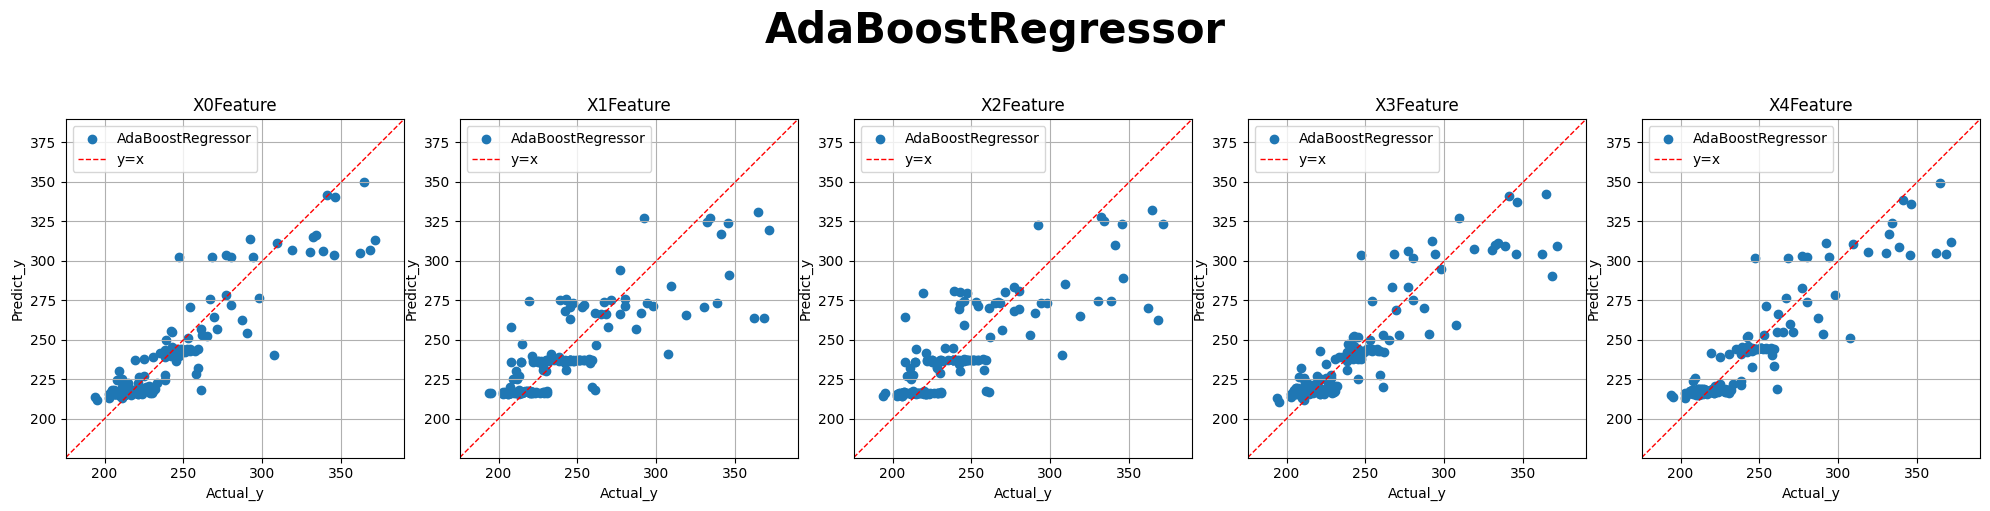

In [524]:
pred_y(ada)

In [ ]:
#Model Rseult
result_model=result_model.sort_values(by=["y_test",'Model','Data_number'], ascending=[True,True,True])
result_model.to_csv('Result_Model.csv',index=False,encoding='utf-8')
#Stacking Result
result_stack = result_stack.sort_values(by=["y_test",'Model','Data_number'], ascending=[True,True,True])
result_stack.to_csv('Result_Stack.csv',index=False,encoding='utf-8')
#Total Result
Model_stack = Model_stack.sort_values(by=["y_test",'Model','Data_number'], ascending=[True,True,True])
Model_stack.to_csv('Total_Result.csv',index=False,encoding='utf-8')

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
Model_stack.groupby(['Data_number','Model']).mean(numeric_only=True)

y_test  y_pred   MAE  RMSE  R^2  adj-R^2  \
Data_number Model                                                             
X1          AdaBoostRegressor      241.78  237.64 12.98 19.39 0.75     0.69   
            DecisionTreeRegressor  241.78  240.39 11.15 17.87 0.79     0.74   
            ElasticNet             241.78  238.80 17.46 26.18 0.55     0.44   
            LinearRegression       241.78  238.40 17.88 26.04 0.55     0.44   
            RandomForestRegressor  241.78  239.17  8.27 13.89 0.87     0.84   
            SVR                    241.78  240.34 10.62 17.82 0.79     0.74   
            Stacking               241.78  240.82  8.26 12.98 0.89     0.86   
            XGBRegressor           241.78  239.48  6.55 10.89 0.92     0.90   
X2          AdaBoostRegressor      241.78  238.15 17.25 25.57 0.57     0.52   
            DecisionTreeRegressor  241.78  236.89 16.25 28.76 0.45     0.39   
            ElasticNet             241.78  238.77 18.33 27.21 0.51     0.45   
            LinearRegression       241.78  238.61 18.44 27.05 0.51     0.46   
            RandomForestRegressor  241.78  238.58 12.84 20.79 0.71     0.68   
            SVR                    241.78  236.63 16.12 25.64 0.56     0.52   
            Stacking               241.78  238.06 13.41 22.18 0.67     0.64   
            XGBRegressor           241.78  237.60 13.55 23.22 0.64     0.60   
X3          AdaBoostRegressor      241.78  238.62 16.90 24.83 0.59     0.55   
            DecisionTreeRegressor  241.78  239.23 16.55 29.16 0.44     0.37   
            ElasticNet             241.78  239.21 18.73 27.60 0.49     0.44   
            LinearRegression       241.78  238.78 18.74 27.34 0.50     0.45   
            RandomForestRegressor  241.78  238.73 12.84 20.94 0.71     0.68   
            SVR                    241.78  238.00 14.23 23.10 0.65     0.61   
            Stacking               241.78  240.97 12.78 20.86 0.71     0.68   
            XGBRegressor           241.78  237.82 14.23 24.39 0.61     0.56   
X4          AdaBoostRegressor      241.78  238.32 13.14 19.81 0.74     0.70   
            DecisionTreeRegressor  241.78  238.66 10.25 17.30 0.80     0.77   
            ElasticNet             241.78  239.04 18.64 27.06 0.51     0.45   
            LinearRegression       241.78  239.22 18.73 27.17 0.51     0.44   
            RandomForestRegressor  241.78  239.36  8.94 15.37 0.84     0.82   
            SVR                    241.78  240.22 12.41 21.97 0.68     0.64   
            Stacking               241.78  239.71  9.38 15.04 0.85     0.83   
            XGBRegressor           241.78  239.84  7.34 12.78 0.89     0.88   
X5          AdaBoostRegressor      241.78  238.23 13.02 19.04 0.76     0.73   
            DecisionTreeRegressor  241.78  239.35  8.71 14.32 0.86     0.85   
            ElasticNet             241.78  238.70 18.07 27.57 0.50     0.43   
            LinearRegression       241.78  238.48 18.02 26.90 0.52     0.46   
            RandomForestRegressor  241.78  238.71  7.52 12.87 0.89     0.88   
            SVR                    241.78  239.65  8.57 15.08 0.85     0.83   
            Stacking               241.78  240.08  8.28 12.85 0.89     0.88   
            XGBRegressor           241.78  239.34  6.75 11.73 0.91     0.90   

                                   Training_time  
Data_number Model                                 
X1          AdaBoostRegressor              12.35  
            DecisionTreeRegressor          24.17  
            ElasticNet                      0.59  
            LinearRegression                0.08  
            RandomForestRegressor         338.62  
            SVR                            26.80  
            Stacking                        0.00  
            XGBRegressor                   80.73  
X2          AdaBoostRegressor              10.56  
            DecisionTreeRegressor          20.61  
            ElasticNet                      0.32  
            LinearRegression                0.03  
  

In [ ]:
result_model.groupby('Model').mean(numeric_only=True)

### **Neural Network**

In [ ]:
#NN
# 베스트 파라미터 세팅
best_params = {
	'units': 256,
	'activation': 'tanh',
	'l2': 0.0001,
	'optimizer': 'adam',
	'epochs': 100,
	'batch_size': 16
}

# 시드 고정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# 베스트 모델 구성
def build_model(input_dim, units, activation, l2, optimizer):
	model = keras.Sequential([
		keras.layers.Dense(units, activation=activation, input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(l2)),
		keras.layers.Dense(units//2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
		keras.layers.Dense(units//4, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
		keras.layers.Dense(1)
	])
	model.compile(optimizer=optimizer, loss='mse')
	return model

# 모델 학습 및 평가
start_time = time.time()

X_train_best, X_test_best = X5_train, X5_test  # 전처리된 베스트 데이터셋 사용
model = build_model(
	input_dim=X_train_best.shape[1],
	units=best_params['units'],
	activation=best_params['activation'],
	l2=best_params['l2'],
	optimizer=best_params['optimizer']
)

history = model.fit(X_train_best, y_train_scaled,
					epochs=best_params['epochs'],
					batch_size=best_params['batch_size'],
					verbose=1)

end_time = time.time()

# 예측 및 역변환
y_pred = model.predict(X_test_best)
y_pred_inverse = y_scale.inverse_transform(y_pred).flatten()
y_test_inverse = y_scale.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# 성능 지표 계산
def adj_r2_score(y_true, y_pred, X_features):
	r2 = r2_score(y_true, y_pred)
	n = len(y_true)
	p = X_features.shape[1]
	return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

mae_NN = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse_NN = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
r2 = r2_score(y_test_inverse, y_pred_inverse)
adj_r2_NN = adj_r2_score(y_test_inverse, y_pred_inverse, X_test_best)

# 결과 출력
print(f"\n🎯 [Best Model Results]")
print(f"Training time: {end_time - start_time:.4f} seconds")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R²: {adj_r2_NN:.4f}")
print(f"MAE: {mae_NN:.4f}")
print(f"RMSE: {rmse_NN:.4f}")

Training time:  74.7350

R-squared (R²): 0.8318515450056825

adjR-squared (R²): 0.6925285394389622

mae_NN : 298.46952767328276

rmse_NN: 476.0674566568935

### **Time Series Analysis**

In [ ]:
# Load file
df = pd.read_csv('data/cleaned/energy_consumption.csv')
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.drop(columns=['Year', 'Month'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Select target
y = df['Avg Electricity Consumption per Household (kWh)']
y = y.resample('MS').mean()
title = 'Avg Electricity Consumption per Household (kWh)'

# y = df['Avg Gas Supply per Household (ton)']
# y = y.resample('MS').mean()
# title = 'Avg Gas Supply per Household (ton)'

In [ ]:
# Check stationarity using Augmented Dickey-Fuller test
adf = adfuller(y.dropna())
print(f"ADF stats: {adf[0]} | p-val: {adf[1]}")

ADF stats: -4.761705376245959 | p-val: 6.434173624426523e-05


In [ ]:
# Split into train and test data
date = '2023-01-01'
y_train, y_test = y[:date], y[date:]

In [ ]:
# SARIMAX
sarimax = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax.fit()
print(sarimax_fit.summary())

                                              SARIMAX Results                                              
Dep. Variable:     Avg Electricity Consumption per Household (kWh)   No. Observations:                   85
Model:                              SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -290.824
Date:                                             Mon, 07 Apr 2025   AIC                            591.647
Time:                                                     14:30:08   BIC                            603.030
Sample:                                                 01-01-2016   HQIC                           596.179
                                                      - 01-01-2023                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [ ]:
# Prediction
y_pred = sarimax_fit.get_prediction(start=y_test.index[0], end=y_test.index[-1])

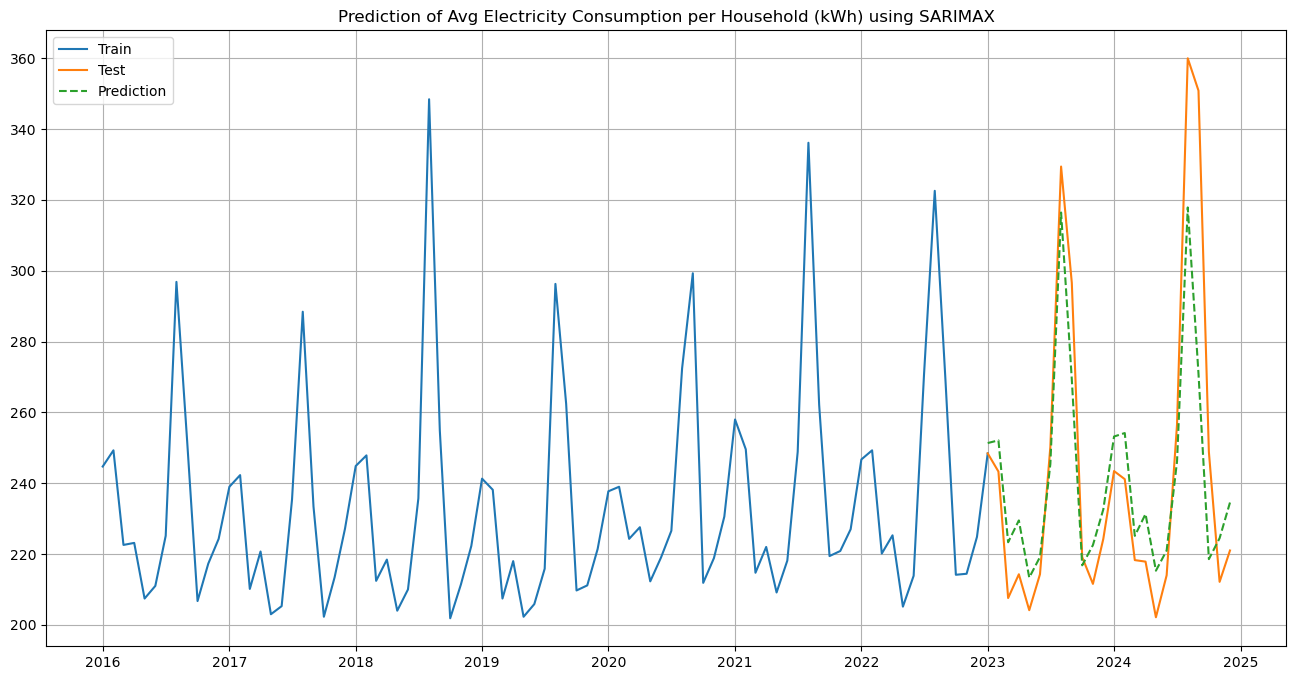

In [ ]:
# Forecast
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred.predicted_mean, label='Prediction', linestyle='--')
plt.legend()
plt.title(f"Prediction of {title} using SARIMAX")
plt.grid()
plt.show()

### Under test

In [ ]:
#NN Hyperparams 선택
Hyperparams = {
	'units': [64, 128, 256],
	'activation': ['relu', 'tanh'],
	'l2': [0.001, 0.0001],
	'optimizer': ['adam'],
	'epochs': [100, 150],
	'batch_size': [16, 32]
}
y_scale=StandardScaler()
# 스케일링 전에 y_train을 2차원 배열로 변환합니다.
y_train_2d = y_train.values.reshape(-1, 1)
y_train_scaled = y_scale.fit_transform(y_train_2d)
# 스케일링 전에 y_test를 2차원 배열로 변환합니다.
y_test_2d = y_test.values.reshape(-1, 1)
y_test_scaled = y_scale.transform(y_test_2d)
# 모델에서 필요한 경우 스케일링 후 y_train_scaled와 y_test_scaled를 다시 1차원으로 변환해야 할 수 있습니다.
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()


# 모델 생성 함수
def build_model(input_dim, units, activation, l2, optimizer):
	model = keras.Sequential([
		keras.layers.Dense(units, activation=activation, input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(l2)),
		keras.layers.Dense(units//2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
		keras.layers.Dense(units//4, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
		keras.layers.Dense(1)
	])
	model.compile(optimizer=optimizer, loss='mse')
	return model

# 탐색 루프
best_score = -np.inf
best_params = None
best_model = None

X_train_ver, X_test_ver = X4_train, X4_test


for params in ParameterGrid(Hyperparams):
	print(f"Trying params: {params}")
	model = build_model(
		input_dim=X_train_ver.shape[1],
		units=params['units'],
		activation=params['activation'],
		l2=params['l2'],
		optimizer=params['optimizer']
	)

	history = model.fit(X_train_ver, y_train_scaled,
						epochs=params['epochs'],
						batch_size=params['batch_size'],
						verbose=0, validation_split=0.2)

	y_pred = model.predict(X_test_ver)
	y_pred = y_scale.inverse_transform(y_pred).flatten()
	y_test_inverse = y_scale.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

	r2 = r2_score(y_test_inverse, y_pred)
	adj_r2 = adj_r2_score(y_test_inverse, y_pred, X_test_ver)

	if adj_r2 > best_score:
		best_score = adj_r2
		best_params = params
		best_model = model

		print(f"✅ New Best Adjusted R²: {best_score:.4f} with {best_params}")

print("\n🎯 Best Hyperparameters Found:")
print(best_params)

In [ ]:
import tensorflow as tf
# 베스트 파라미터
best_params = {
    'units': 256,
    'activation': 'tanh',
    'l2': 0.0001,
    'optimizer': 'adam',
    'epochs': 100,
    'batch_size': 16
}

y_scale=StandardScaler()
y_train_2d = y_train.values.reshape(-1, 1)
y_train_scaled = y_scale.fit_transform(y_train_2d)
y_test_2d = y_test.values.reshape(-1, 1)
y_test_scaled = y_scale.transform(y_test_2d)
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

# 시드 고정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# ✅ 베스트 모델 구성
def build_model(input_dim, units, activation, l2, optimizer):
    model = keras.Sequential([
        keras.layers.Dense(units, activation=activation, input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(units//2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(units//4, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# 모델 학습 및 평가
start_time = time.time()

X_train_best, X_test_best = X4_train, X4_test  # 전처리된 베스트 데이터셋 사용
model = build_model(
    input_dim=X_train_best.shape[1],
    units=best_params['units'],
    activation=best_params['activation'],
    l2=best_params['l2'],
    optimizer=best_params['optimizer']
)

history = model.fit(X_train_best, y_train_scaled,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

end_time = time.time()

# 예측 및 역변환
y_pred = model.predict(X_test_best)
y_pred_inverse = y_scale.inverse_transform(y_pred).flatten()
y_test_inverse = y_scale.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

mae_NN = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse_NN = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
r2 = r2_score(y_test_inverse, y_pred_inverse)
adj_r2_NN = adj_r2_score(y_test_inverse, y_pred_inverse, X_test_best)

# 결과 출력
print(f"\n [Best Model Results]")
print(f"Training time: {end_time - start_time:.4f} seconds")
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R²: {adj_r2_NN:.4f}")
print(f"MAE: {mae_NN:.4f}")
print(f"RMSE: {rmse_NN:.4f}")

/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8269
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4814 
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3827 
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3244 
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2751 
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2430 
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2261 
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2215 
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2250 
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2300 
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2104 
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1779 
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1527 
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1345 
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

In [440]:
result_model=pd.read_csv('Result_Model.csv')
result_stack=pd.read_csv('Result_Stack.csv')

In [480]:
#New Data predict
#df split
df = pd.read_csv('energy_consumption.csv')
# df_new = df[df['Year']<=2024] #2023 2022 2021
# test_condition= (df['Year'] == 2024) #2023 2022 2021
# df_test=df[test_condition]
df_train=df

In [487]:
#Train data / Test Data
#Train
X=df_train.drop(columns=['Avg Electricity Consumption per Household (kWh)'])
y=df_train['Avg Electricity Consumption per Household (kWh)']
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.3,random_state=42)


In [462]:
#Test
X_test = df_test.drop(columns=['Avg Electricity Consumption per Household (kWh)'])
y_test = df_test['Avg Electricity Consumption per Household (kWh)']

In [488]:
#Feature Selection->X4
X_test=X_test[stepwise_cols]
X_train=X_train[stepwise_cols]
X_val=X_val[stepwise_cols]

In [489]:
data={'Number of Tropical Nights':12,'Year':2025,'Avg Vapor Pressure (hPa)':30.0,'Avg Dew Point Temp (Celsius)':23.1,'Avg Min Supercool Temp (Celsius)':22.5,'Avg Local Pressure (hPa)':1020.3,
     'Month':7,'Avg Cloud Cover (1/10)':3.8,'Avg Ground Temp (Celsius)':29.3,'Avg Min Temperature (Celsius)':22.6 }

In [490]:
X_test=pd.DataFrame(data,index=[0])
X_test

,Number of Tropical Nights,Year,Avg Vapor Pressure (hPa),Avg Dew Point Temp (Celsius),Avg Min Supercool Temp (Celsius),Avg Local Pressure (hPa),Month,Avg Cloud Cover (1/10),Avg Ground Temp (Celsius),Avg Min Temperature (Celsius)
0,12,2025,30.00,23.10,22.50,1020.30,7,3.80,29.30,22.60


In [477]:
X_train

,Number of Tropical Nights,Year,Avg Vapor Pressure (hPa),Avg Dew Point Temp (Celsius),Avg Min Supercool Temp (Celsius),Avg Local Pressure (hPa),Month,Avg Cloud Cover (1/10),Avg Ground Temp (Celsius),Avg Min Temperature (Celsius)
182,0.00,2022,7.00,0.60,0.10,1010.80,3,5.00,11.30,3.80
575,0.00,2018,4.90,-6.60,-5.10,1014.80,12,4.40,3.20,-0.10
399,0.00,2022,10.70,6.30,7.20,1008.80,4,4.30,20.20,9.80
583,8.00,2019,28.00,22.80,20.90,997.60,8,5.60,28.00,23.10
223,14.00,2016,26.50,21.80,21.90,998.20,8,4.80,33.60,23.50
...,...,...,...,...,...,...,...,...,...,...
71,0.00,2021,5.10,-4.30,-1.90,1014.30,12,1.90,4.70,1.90
106,0.00,2024,9.80,5.50,4.30,1012.40,11,3.70,13.10,10.40
270,0.00,2021,4.20,-6.90,-9.30,1016.60,1,4.60,0.00,-6.00
435,0.00,2016,10.60,7.50,4.70,1005.10,4,5.20,15.70,9.00


In [491]:
#Scaler
scale=StandardScaler()
numeric=X_train.select_dtypes(include=['number']).columns
X_train[numeric]=scale.fit_transform(X_train[numeric])
X_val[numeric]=scale.transform(X_val[numeric])
X_test[numeric]=scale.transform(X_test[numeric])

In [410]:
#one-hot-encoding
X_train=pd.get_dummies(data=X_train, columns=['Region'], dtype=int)
X_val=pd.get_dummies(data=X_val, columns=['Region'], dtype=int)
X_test=pd.get_dummies(data=X_test, columns=['Region'], dtype=int)

KeyError: "None of [Index(['Region'], dtype='object')] are in the [columns]"

In [288]:
instant_condition=((result_model['Data_number']=='X5')&(result_model['y_test']==result_high_pred))
model_get=result_model[instant_condition]
model_get

,y_test,y_pred,MAE,RMSE,R^2,adj-R^2,Model,Training_time,Data_number,best_params
4,194.00,216.05,13.02,19.04,0.76,0.73,AdaBoostRegressor,8.98,X5,"[['learning_rate', 0.01], ['n_estimators', 100]]"
9,194.00,193.12,8.71,14.32,0.86,0.85,DecisionTreeRegressor,16.56,X5,"[['criterion', 'squared_error'], ['max_depth',..."
14,194.00,200.36,18.07,27.57,0.50,0.43,ElasticNet,0.28,X5,"[['alpha', 0.1], ['l1_ratio', 0.9]]"
19,194.00,199.96,18.02,26.90,0.52,0.46,LinearRegression,0.03,X5,"[['fit_intercept', True]]"
24,194.00,199.27,7.52,12.87,0.89,0.88,RandomForestRegressor,183.36,X5,"[['bootstrap', True], ['max_depth', 20], ['min..."
29,194.00,194.54,8.57,15.08,0.85,0.83,SVR,25.22,X5,"[['C', 1000], ['epsilon', 0.3], ['kernel', 'rb..."
34,194.00,194.24,6.75,11.73,0.91,0.90,XGBRegressor,40.26,X5,"[['learning_rate', 0.1], ['max_depth', 3], ['n..."


In [495]:
from sklearn.linear_model import ElasticNet,LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBRegressor

#인스턴스 model(param)
instantiated_models_info = []
#시각화 이름
visual_df_name=[]
num=0
#첫번째 y_pred에 있는 모델만 출력
result_high_pred=result_model.iloc[0]['y_test']
instant_condition=((result_model['Data_number']=='X4')&(result_model['y_test']==result_high_pred))
model_get=result_model[instant_condition]

#반복을 통해서 추출
for index,row in model_get.iterrows():
    model_name_str=row['Model']
    params_list_of_lists = row['best_params']
    params_list_of_lists = eval(params_list_of_lists)


    #모델명 클래스 찾기
    model_class = None #초기화
    model_maping={
        'LinearRegression':LinearRegression,
        'ElasticNet':ElasticNet,
        'RandomForestRegressor':RandomForestRegressor,
        'AdaBoostRegressor':AdaBoostRegressor,
        'DecisionTreeRegressor':DecisionTreeRegressor,
        'SVR':SVR,
        'XGBRegressor':XGBRegressor
    }
    model_class = model_maping.get(model_name_str)

    #하이퍼파라미터 리스트->딕션너리
    hyperparams_dict = {} # 최종 딕셔너리 초기화
    hyperparams_dict = dict(params_list_of_lists)


    #모델 인스턴스 생성
    model = model_class(**hyperparams_dict)


    #모델 저장
    instantiated_models_info.append({'name':model_name_str,'instance':model})
    print(num)
    #모델 훈련
    start_time=time.time()
    model.fit(X_train,y_train)
    end_time=time.time()
    y_pred_test = model.predict(X_test)
    print(y_pred_test,model_name_str)
    # #val,test 예측
    # y_pred_val = model.predict(X_val)
    # y_pred_test = model.predict(X_test)

    # #val metric
    # val_MAE=mean_absolute_error(y_val,y_pred_val)
    # val_RMSE=np.sqrt(mean_squared_error(y_val,y_pred_val))
    # val_R2=r2_score(y_val,y_pred_val)
    # val_adj_r2=adj_r2_score(y_val,y_pred_val,X_val)

    # #test metric
    # test_MAE=mean_absolute_error(y_test,y_pred_test)
    # test_RMSE=np.sqrt(mean_squared_error(y_test,y_pred_test))
    # test_R2=r2_score(y_test,y_pred_test)
    # test_adj_r2=adj_r2_score(y_test,y_pred_test,X_test)

    # #val,test DF
    # val_df=pd.DataFrame({'y_test':y_test,
    #                      'y_pred':y_pred_test,
    #                      'val_MAE':val_MAE,
    #                      'test_MAE':test_MAE,
    #                      'val_RMSE':val_RMSE,
    #                      'test_RMSE':test_RMSE,
    #                      'val_R2':val_R2,
    #                      'test_R2':test_R2,
    #                      'val_adj_R2':val_adj_r2,
    #                      'test_adj_R2':test_adj_r2})
    # val_df['Model_n']= model_name_str



    #visual_df

#     visual_df=pd.DataFrame({'y_test':y_test,
#                          'y_pred':y_pred_test})
#     visual_df['Model_n']= model_name_str
#     name=model_name_str+'_pred'
#     globals()[name]=pd.concat([df_test,visual_df],axis=1)
#     visual_df_name.append(name)

#     if num == 0:
#         new_data_df=val_df
#     else:
#         new_data_df=pd.concat([new_data_df,val_df])
#     num+=1
# for i in range(len(visual_df_name)):
#     if i==0:
#         All_new_data=globals()[visual_df_name[i]]
#     else:
#         All_new_data=pd.concat([All_new_data,globals()[visual_df_name[i]]])


0
[256.] AdaBoostRegressor
0
[247.88888889] DecisionTreeRegressor
0
[344.1809887] ElasticNet
0
[365.88741194] LinearRegression
0
[243.77] RandomForestRegressor
0
[311.38632404] SVR
0
[256.17755] XGBRegressor


In [426]:
new_data_df

,y_test,y_pred,val_MAE,test_MAE,val_RMSE,test_RMSE,val_R2,test_R2,val_adj_R2,test_adj_R2,Model_n
499,368.00,260.97,14.95,17.30,21.59,26.21,0.60,0.43,0.52,0.11,LinearRegression
499,368.00,298.88,11.04,11.40,15.49,16.73,0.79,0.77,0.76,0.64,AdaBoostRegressor
499,368.00,303.16,6.91,9.57,9.29,15.43,0.93,0.80,0.91,0.69,RandomForestRegressor
499,368.00,313.91,9.50,12.32,15.10,20.04,0.80,0.67,0.77,0.48,NN
499,368.00,323.44,8.91,12.95,12.90,20.63,0.86,0.65,0.83,0.45,DecisionTreeRegressor
...,...,...,...,...,...,...,...,...,...,...,...
274,197.00,204.10,8.29,11.52,12.25,16.00,0.87,0.79,0.85,0.67,Stacking
274,197.00,206.39,8.91,12.95,12.90,20.63,0.86,0.65,0.83,0.45,DecisionTreeRegressor
274,197.00,200.68,14.95,17.30,21.59,26.21,0.60,0.43,0.52,0.11,LinearRegression
274,197.00,200.76,6.91,9.57,9.29,15.43,0.93,0.80,0.91,0.69,RandomForestRegressor


In [466]:
# #스태킹
stack_condition=((result_stack['Data_number']=='X4')&(result_stack['y_test']==result_high_pred))
stack_get=result_stack[stack_condition]
stack_get=stack_get['best_params'].iloc[0]
stack_get=eval(stack_get)

meta_model_name = stack_get[0][1]
base_mdoel_name = stack_get[1]
print(meta_model_name)

#메타모델 인스턴스
for item_dict in instantiated_models_info:
    if item_dict.get('name') == meta_model_name:
        found_meta_instance=item_dict['instance']

        break

#베이스 모델 인스턴스
base_model=[]

for i in range(len(base_mdoel_name)):
    for item_dict in instantiated_models_info:
        if item_dict.get('name') == base_mdoel_name[i]:
            found_base=item_dict['instance']
            base_name=item_dict['name']
            base_model.append((base_name,found_base))
            break

base_model
# base_model
ladder = StackingRegressor(estimators=base_model,
                   final_estimator=found_meta_instance,
                    cv=5)

ladder.fit(X_train,y_train)

y_pred_val = ladder.predict(X_val)
y_pred_test = ladder.predict(X_test)

#val metric
val_MAE=mean_absolute_error(y_val,y_pred_val)
val_RMSE=np.sqrt(mean_squared_error(y_val,y_pred_val))
val_R2=r2_score(y_val,y_pred_val)
val_adj_r2=adj_r2_score(y_val,y_pred_val,X_val)

#test metric
test_MAE=mean_absolute_error(y_test,y_pred_test)
test_RMSE=np.sqrt(mean_squared_error(y_test,y_pred_test))
test_R2=r2_score(y_test,y_pred_test)
test_adj_r2=adj_r2_score(y_test,y_pred_test,X_test)

#val,test DF
val_df=pd.DataFrame({'y_test':y_test,
                    'y_pred':y_pred_test,
                    'val_MAE':val_MAE,
                    'test_MAE':test_MAE,
                    'val_RMSE':val_RMSE,
                    'test_RMSE':test_RMSE,
                    'val_R2':val_R2,
                    'test_R2':test_R2,
                    'val_adj_R2':val_adj_r2,
                    'test_adj_R2':test_adj_r2})
val_df['Model_n']= 'Stacking'
new_data_df=pd.concat([new_data_df,val_df])

#visual_df

visual_df=pd.DataFrame({'y_test':y_test,
                        'y_pred':y_pred_test})
visual_df['Model_n']= 'Stacking'
name='Stacking'+'_pred'
globals()[name]=pd.concat([df_test,visual_df],axis=1)
visual_df_name.append(name)

XGBRegressor


In [210]:
import tensorflow as tf

In [467]:
#NN
best_params = {
    'units': 256,
    'activation': 'tanh',
    'l2': 0.0001,
    'optimizer': 'adam',
    'epochs': 100,
    'batch_size': 16
}

y_scale=StandardScaler()
y_train_2d = y_train.values.reshape(-1, 1)
y_train_scaled = y_scale.fit_transform(y_train_2d)


# 시드 고정
seed = 42
np.random.seed(seed)

# ✅ 베스트 모델 구성
def build_model(input_dim, units, activation, l2, optimizer):
    model = keras.Sequential([
        keras.layers.Dense(units, activation=activation, input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(units//2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(units//4, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# 모델 학습 및 평가
start_time = time.time()

  # 전처리된 베스트 데이터셋 사용
model = build_model(
    input_dim=X_train.shape[1],
    units=best_params['units'],
    activation=best_params['activation'],
    l2=best_params['l2'],
    optimizer=best_params['optimizer']
)

history = model.fit(X_train, y_train_scaled,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

end_time = time.time()

# 예측 및 역변환
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)
y_pred_val= y_scale.inverse_transform(y_pred_val).flatten()
y_pred_test = y_scale.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()


#val metric
val_MAE=mean_absolute_error(y_val,y_pred_val)
val_RMSE=np.sqrt(mean_squared_error(y_val,y_pred_val))
val_R2=r2_score(y_val,y_pred_val)
val_adj_r2=adj_r2_score(y_val,y_pred_val,X_val)

#test metric
test_MAE=mean_absolute_error(y_test,y_pred_test)
test_RMSE=np.sqrt(mean_squared_error(y_test,y_pred_test))
test_R2=r2_score(y_test,y_pred_test)
test_adj_r2=adj_r2_score(y_test,y_pred_test,X_test)

#val,test DF
val_df=pd.DataFrame({'y_test':y_test,
                    'y_pred':y_pred_test,
                    'val_MAE':val_MAE,
                    'test_MAE':test_MAE,
                    'val_RMSE':val_RMSE,
                    'test_RMSE':test_RMSE,
                    'val_R2':val_R2,
                    'test_R2':test_R2,
                    'val_adj_R2':val_adj_r2,
                    'test_adj_R2':test_adj_r2})
val_df['Model_n']= 'NN'
new_data_df=pd.concat([new_data_df,val_df])

#visual_df

visual_df=pd.DataFrame({'y_test':y_test,
                        'y_pred':y_pred_test})
visual_df['Model_n']= 'NN'
name='NN'+'_pred'
globals()[name]=pd.concat([df_test,visual_df],axis=1)
visual_df_name.append(name)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.8646
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5985
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4534
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4618
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3760
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3642
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3858
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4320
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3196
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3394
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2659
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2286
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2495
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2193
Epoch 15/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2035
Epoc

In [468]:
#Full model set
for i in range(len(visual_df_name)):
    if i==0:
        All_new_data=globals()[visual_df_name[i]]
    else:
        All_new_data=pd.concat([All_new_data,globals()[visual_df_name[i]]])

In [470]:
pd.options.display.float_format = '{:.2f}'.format
new_data_df=new_data_df.sort_values(by=['y_test'],ascending=False)
val=new_data_df[['val_MAE','val_RMSE','val_R2','val_adj_R2','Model_n']]
test=new_data_df[['test_MAE','test_RMSE','test_R2','test_adj_R2','Model_n']]

val=val.head(9)
test=test.head(9)

val=val.sort_values(by=['val_adj_R2'],ascending=False)
test=test.sort_values(by=['test_adj_R2'],ascending=False)

In [436]:
val

,val_MAE,val_RMSE,val_R2,val_adj_R2,Model_n
499,5.87,9.18,0.93,0.91,XGBRegressor
499,6.91,9.29,0.93,0.91,RandomForestRegressor
499,8.29,12.25,0.87,0.85,Stacking
499,8.91,12.90,0.86,0.83,DecisionTreeRegressor
499,9.50,15.10,0.80,0.77,NN
499,11.04,15.49,0.79,0.76,AdaBoostRegressor
499,9.83,15.79,0.78,0.75,SVR
499,14.95,21.59,0.60,0.52,LinearRegression
499,14.79,21.72,0.59,0.52,ElasticNet


from matplotlib import pyplot as plt
val['val_MAE'].plot(kind='hist', bins=20, title='val_MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val['val_RMSE'].plot(kind='hist', bins=20, title='val_RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val['val_R2'].plot(kind='hist', bins=20, title='val_R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val['val_adj_R2'].plot(kind='hist', bins=20, title='val_adj_R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val.plot(kind='scatter', x='val_MAE', y='val_RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val.plot(kind='scatter', x='val_RMSE', y='val_R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val.plot(kind='scatter', x='val_R2', y='val_adj_R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['val_RMSE']
  ys = series['val_MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = val.sort_values('val_RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_RMSE')
_ = plt.ylabel('val_MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['val_RMSE']
  ys = series['val_R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = val.sort_values('val_RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_RMSE')
_ = plt.ylabel('val_R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['val_RMSE']
  ys = series['val_adj_R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = val.sort_values('val_RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_RMSE')
_ = plt.ylabel('val_adj_R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['val_RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'val_RMSE'}, axis=1)
              .sort_values('val_RMSE', ascending=True))
  xs = counted['val_RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = val.sort_values('val_RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
val['val_MAE'].plot(kind='line', figsize=(8, 4), title='val_MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
val['val_RMSE'].plot(kind='line', figsize=(8, 4), title='val_RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
val['val_R2'].plot(kind='line', figsize=(8, 4), title='val_R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
val['val_adj_R2'].plot(kind='line', figsize=(8, 4), title='val_adj_R2')
plt.gca().spines[['top', 'right']].set_visible(False)

In [276]:
total_result=pd.read_csv('Total_Result.csv')
total_result=total_result.head(40)

total_result=total_result.sort_values(by=['Model','adj-R^2'],ascending=[True,False])
summarize_total=total_result[0::5]
summarize_total.to_csv('summarize_total.csv',index=False)

In [471]:
test

,test_MAE,test_RMSE,test_R2,test_adj_R2,Model_n
511,8.13,10.63,0.90,0.88,RandomForestRegressor
511,8.18,11.17,0.89,0.87,Stacking
511,8.59,11.43,0.88,0.87,DecisionTreeRegressor
511,8.87,12.17,0.87,0.85,NN
511,8.47,12.67,0.86,0.84,XGBRegressor
511,11.33,14.51,0.81,0.79,AdaBoostRegressor
511,10.77,16.53,0.76,0.72,SVR
511,13.58,18.04,0.71,0.67,ElasticNet
511,13.95,18.41,0.70,0.66,LinearRegression


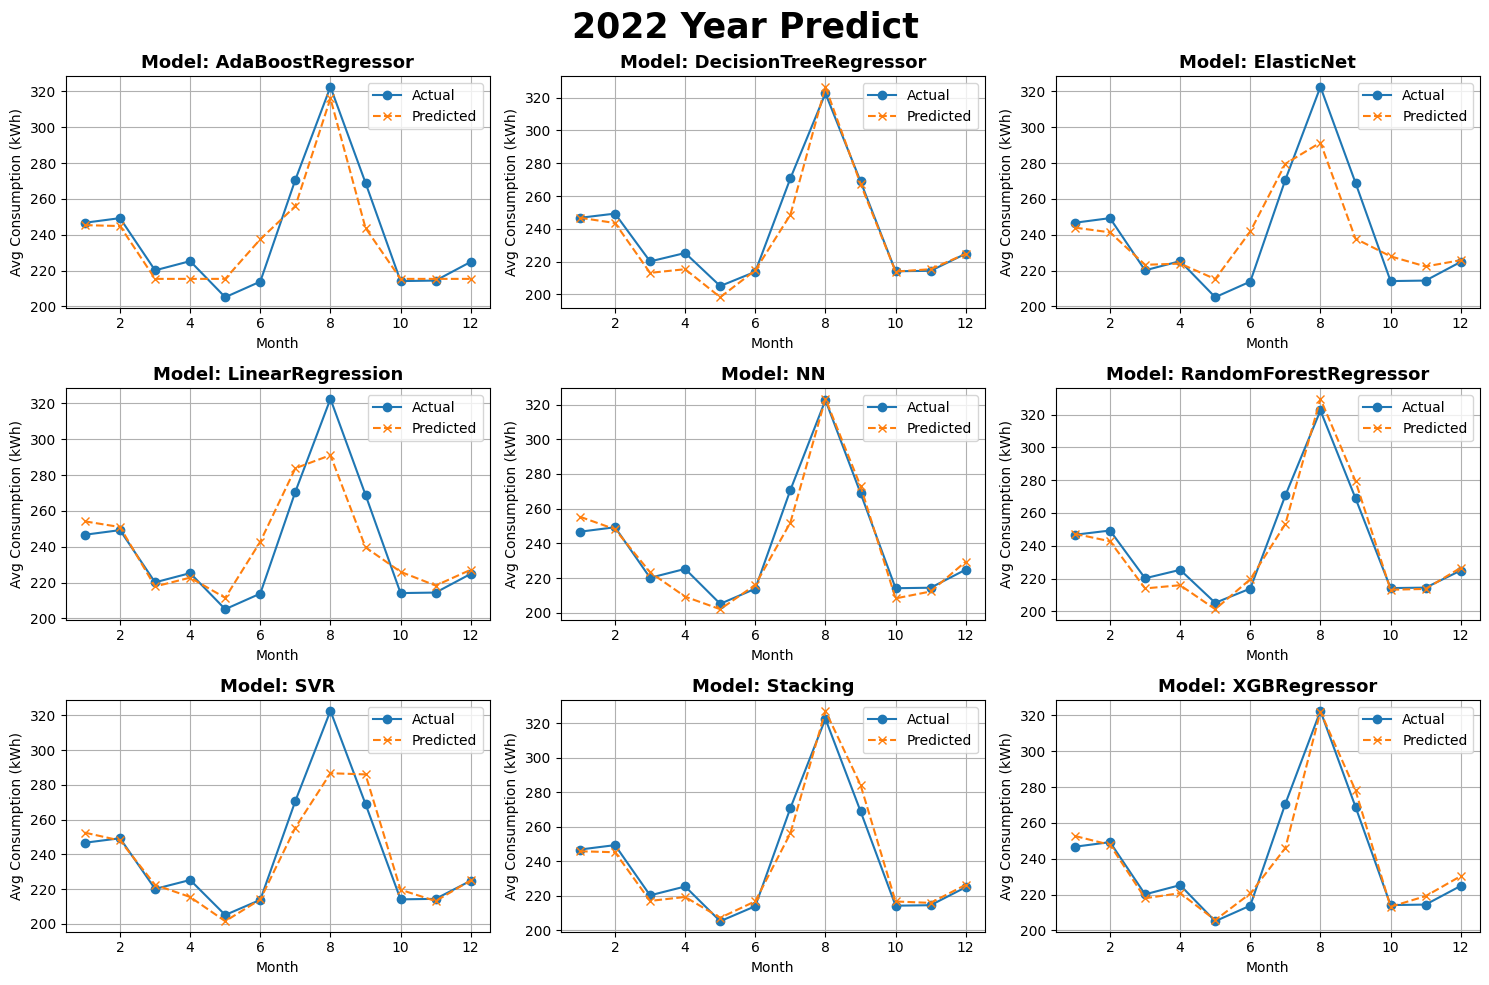

In [472]:

Actual_y = All_new_data.groupby(['Model_n', 'Month'])['y_test'].mean()
Predic_y = All_new_data.groupby(['Model_n', 'Month'])['y_pred'].mean()

unique_model = Actual_y.index.get_level_values('Model_n').unique()
n_model = len(unique_model)
n_cols = 3
n_rows = math.ceil(n_model / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), squeeze=False)
fig.suptitle('2022 Year Predict', fontsize=25, fontweight='bold')
axes_flat = axes.flatten()
last_plotted_idx = -1


for i, model_name in enumerate(unique_model):
    # 현재 모델이름에 위치하는 ax축 선택
    ax = axes_flat[i]
    last_plotted_idx = i
    actual_data = Actual_y.loc[model_name]
    predict_data = Predic_y.loc[model_name]

    # 현재 축(ax)에 실제값과 예측값 그래프 그리기
    ax.plot(actual_data, label='Actual',marker='o')
    ax.plot(predict_data, label='Predicted',  linestyle='--', marker='x')

    # 각 서브플롯 꾸미기
    ax.set_title(f'Model: {model_name}',fontsize=13,fontweight='bold')      # 플롯 제목 설정
    ax.set_xlabel('Month')                    # x축 레이블
    ax.set_ylabel('Avg Consumption (kWh)')    # y축 레이블 (단위 확인 필요)
    ax.grid(True)                             # 그리드 표시
    ax.legend()                               # 범례 표시 확실히 하기

for j in range(last_plotted_idx+1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# 전체 레이아웃 조정 및 플롯 보여주기
plt.tight_layout()
# tight_layout() 호출 후 suptitle 공간 확보

plt.show()
